# Fashion-MNIST CNN Classification Demo

This notebook demonstrates how to use the Fashion-MNIST CNN project for image classification.

## Project Overview

This project implements a Convolutional Neural Network (CNN) for classifying Fashion-MNIST images into 10 categories:
- T-shirt/top
- Trouser
- Pullover
- Dress
- Coat
- Sandal
- Shirt
- Sneaker
- Bag
- Ankle boot

In [2]:
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath('')))

import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from cnnFashionMnist.dataset import prepare_datasets, create_data_loaders, get_transforms
from cnnFashionMnist.modeling.model import create_model
from cnnFashionMnist.modeling.train import train_model
from cnnFashionMnist.modeling.predict import load_model, predict_batch, evaluate_model
from cnnFashionMnist.plots import plot_sample_images, plot_training_history
from cnnFashionMnist.config import (
    RAW_DATA_DIR, PROCESSED_DATA_DIR, MODELS_DIR, FIGURES_DIR,
    DATASET_CONFIG, TRAINING_CONFIG, DEVICE_CONFIG, AUGMENTATION_CONFIG
)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Display configuration info
print(f"Target accuracy: {TRAINING_CONFIG.get('target_accuracy', 'N/A')}")
print(f"Dataset: {DATASET_CONFIG['name']} with {DATASET_CONFIG['num_classes']} classes")

2025-06-26 14:50:47.808 | INFO     | cnnFashionMnist.config:<module>:12 - PROJ_ROOT path is: C:\Users\david\Projects\CNN-Fashion-MNIST


2025-06-26 14:50:47.812 | INFO     | cnnFashionMnist.config:<module>:171 - Device: cpu
2025-06-26 14:50:47.813 | INFO     | cnnFashionMnist.config:<module>:172 - CUDA available: False
2025-06-26 14:50:47.813 | INFO     | cnnFashionMnist.config:<module>:173 - Target accuracy: 88.0%
Using device: cpu
CUDA available: False
Target accuracy: N/A
Dataset: Fashion-MNIST with 10 classes


In [3]:
# Prepare datasets using config values
from typing import cast
from collections.abc import Sized

print("Preparing Fashion-MNIST dataset...")
train_dataset, val_dataset, test_dataset = prepare_datasets(
    RAW_DATA_DIR, 
    PROCESSED_DATA_DIR, 
    val_split=TRAINING_CONFIG["val_split"], 
    random_seed=TRAINING_CONFIG["random_seed"]
)

# Cast datasets to Sized to satisfy type checker
train_size = len(cast(Sized, train_dataset))
val_size = len(cast(Sized, val_dataset))
test_size = len(cast(Sized, test_dataset))

print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Test samples: {test_size}")

# Show split information
total_train = train_size + val_size
print(f"Train/Val split: {train_size}/{val_size} ({train_size/total_train:.1%}/{val_size/total_train:.1%})")

Preparing Fashion-MNIST dataset...
2025-06-26 14:50:56.491 | INFO     | cnnFashionMnist.dataset:download_fashion_mnist:84 - Downloading Fashion-MNIST dataset...


2025-06-26 14:50:56.741 | SUCCESS  | cnnFashionMnist.dataset:download_fashion_mnist:97 - Fashion-MNIST dataset downloaded successfully.
2025-06-26 14:50:56.747 | INFO     | cnnFashionMnist.dataset:prepare_datasets:155 - Training samples: 60000, Test samples: 10000
2025-06-26 14:50:56.747 | INFO     | cnnFashionMnist.dataset:prepare_datasets:156 - Image shape: (28, 28), Data type: uint8
2025-06-26 14:50:56.759 | INFO     | cnnFashionMnist.dataset:prepare_datasets:157 - Data range: [0, 255]
2025-06-26 14:50:56.839 | INFO     | cnnFashionMnist.dataset:prepare_datasets:209 - Dataset prepared - Train: 54000, Val: 6000, Test: 10000
Training samples: 54000
Validation samples: 6000
Test samples: 10000
Train/Val split: 54000/6000 (90.0%/10.0%)


### `prepare_datasets()` Function

#### Purpose
Downloads raw Fashion-MNIST data and creates train/validation/test datasets with proper preprocessing.
##### Step-by-Step Process
**1. Download Raw Data**
- Downloads from Fashion-MNIST official source (~30MB)
- Gets 60,000 training + 10,000 test images
- Raw data: 28×28 grayscale images, pixel values 0-255

**2. Convert to NumPy Arrays**

**3. Create Train/Validation Split**

**4. Apply Data Transforms**

**5. Data Transforms Detail**
```
def get_transforms(train: bool = True):
    if train:
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(10),        # ±10° rotation
            transforms.RandomHorizontalFlip(0.5), # 50% chance of flip
            transforms.ToTensor(),                 # Convert to tensor
            transforms.Normalize((0.5,), (0.5,))  # [0,1] → [-1,1]
        ])
    else:
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))  # Only normalization
        ])
```

In [5]:
# Create data loaders using config values
train_loader, val_loader, test_loader = create_data_loaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=TRAINING_CONFIG["batch_size"], 
    num_workers=DEVICE_CONFIG["num_workers"]
)

# Cast DataLoader to Sized for type checker
train_batches = len(cast(Sized, train_loader))
val_batches = len(cast(Sized, val_loader))
test_batches = len(cast(Sized, test_loader))

print(f"Training batches: {train_batches} (batch size: {TRAINING_CONFIG['batch_size']})")
print(f"Validation batches: {val_batches}")
print(f"Test batches: {test_batches}")
print(f"Using {DEVICE_CONFIG['num_workers']} worker processes for data loading")

Training batches: 844 (batch size: 64)
Validation batches: 94
Test batches: 157
Using 2 worker processes for data loading


### `create_data_loaders()` Function

#### Purpose
Converts datasets into efficient data loaders for batch processing during training.
##### DataLoader Creation
**1. Training Loader**
- Shuffling: Critical for training - prevents model from learning data order
- Result: 844 batches (54,000 ÷ 64 = 843.75 → 844)

**2. Validation Loader**
- No shuffling: Consistent evaluation order
- Result: 94 batches (6,000 ÷ 64 = 93.75 → 94)

**3. Test Loader**
- Result: 157 batches (10,000 ÷ 64 = 156.25 → 157)

## 2. Visualize Sample Data

Let's look at some sample images from the dataset:

## 3. Data Augmentation Examples

Let's visualize how data augmentation transforms our training images:

2025-06-19 20:14:59.080 | INFO     | cnnFashionMnist.plots:plot_data_augmentation_examples:686 - Data augmentation examples saved to C:\Users\david\Projects\CNN-Fashion-MNIST\reports\figures\data_augmentation_examples_demo.png


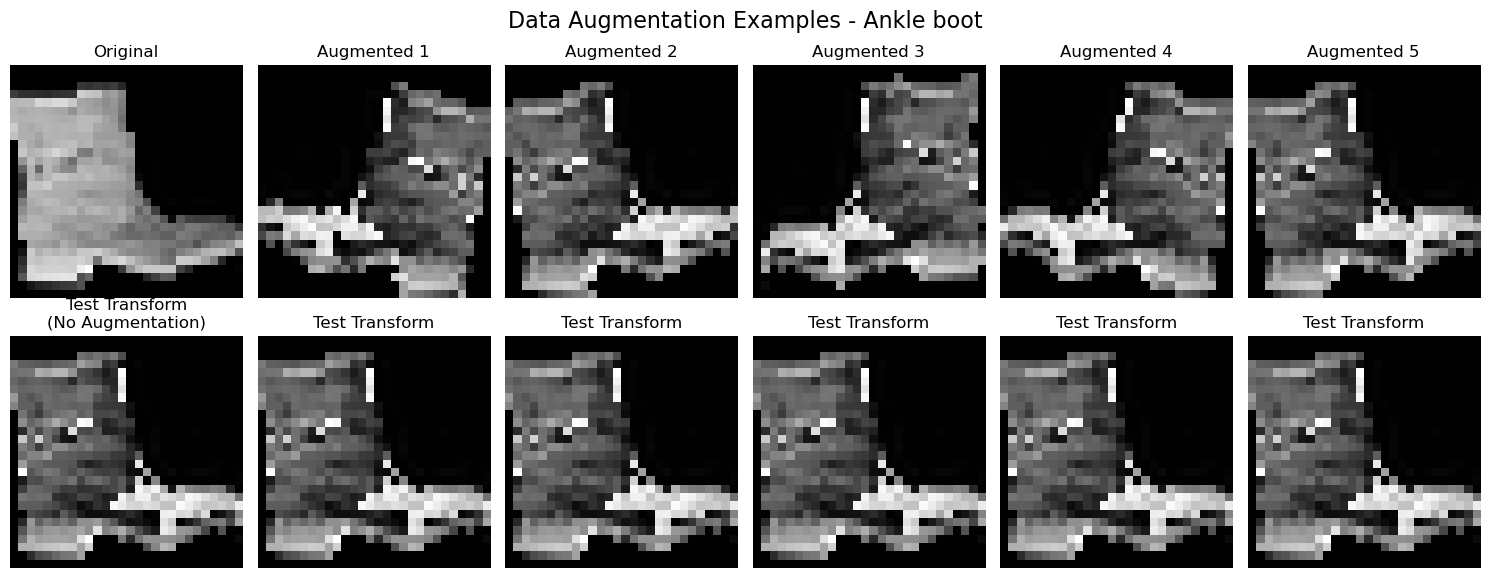

Sample class: Ankle boot
Sample label: 9
Number of augmentation examples: 5
Transforms applied: rotation, horizontal_flip, normalization

Augmentation configuration:
Training transforms:
  - Random rotation: ±10°
  - Random horizontal flip: 50% chance
  - Normalization: mean=(0.5,), std=(0.5,)
Validation/Test transforms:
  - Only normalization (no augmentation)


In [54]:
# Plot data augmentation examples using the plot_data_augmentation_examples function
from cnnFashionMnist.plots import plot_data_augmentation_examples

augmentation_plot_path = FIGURES_DIR / "data_augmentation_examples_demo.png"

# Use the plot_data_augmentation_examples function with both inline display AND file saving
aug_stats = plot_data_augmentation_examples(
    train_dataset,
    DATASET_CONFIG["class_names"],
    output_path=augmentation_plot_path,  # Save to file
    num_examples=5,  # Show 5 augmented examples
    show_inline=True  # Display inline in notebook
)

# Display the returned augmentation information
print(f"Sample class: {aug_stats['sample_class']}")
print(f"Sample label: {aug_stats['sample_label']}")
print(f"Number of augmentation examples: {aug_stats['num_examples']}")
print(f"Transforms applied: {aug_stats['transforms_applied']}")

print(f"\nAugmentation configuration:")
print(f"Training transforms:")
print(f"  - Random rotation: ±{AUGMENTATION_CONFIG['train']['random_rotation']}°")
print(f"  - Random horizontal flip: {AUGMENTATION_CONFIG['train']['random_horizontal_flip']*100:.0f}% chance")
print(f"  - Normalization: mean={DATASET_CONFIG['mean']}, std={DATASET_CONFIG['std']}")
print(f"Validation/Test transforms:")
print(f"  - Only normalization (no augmentation)")

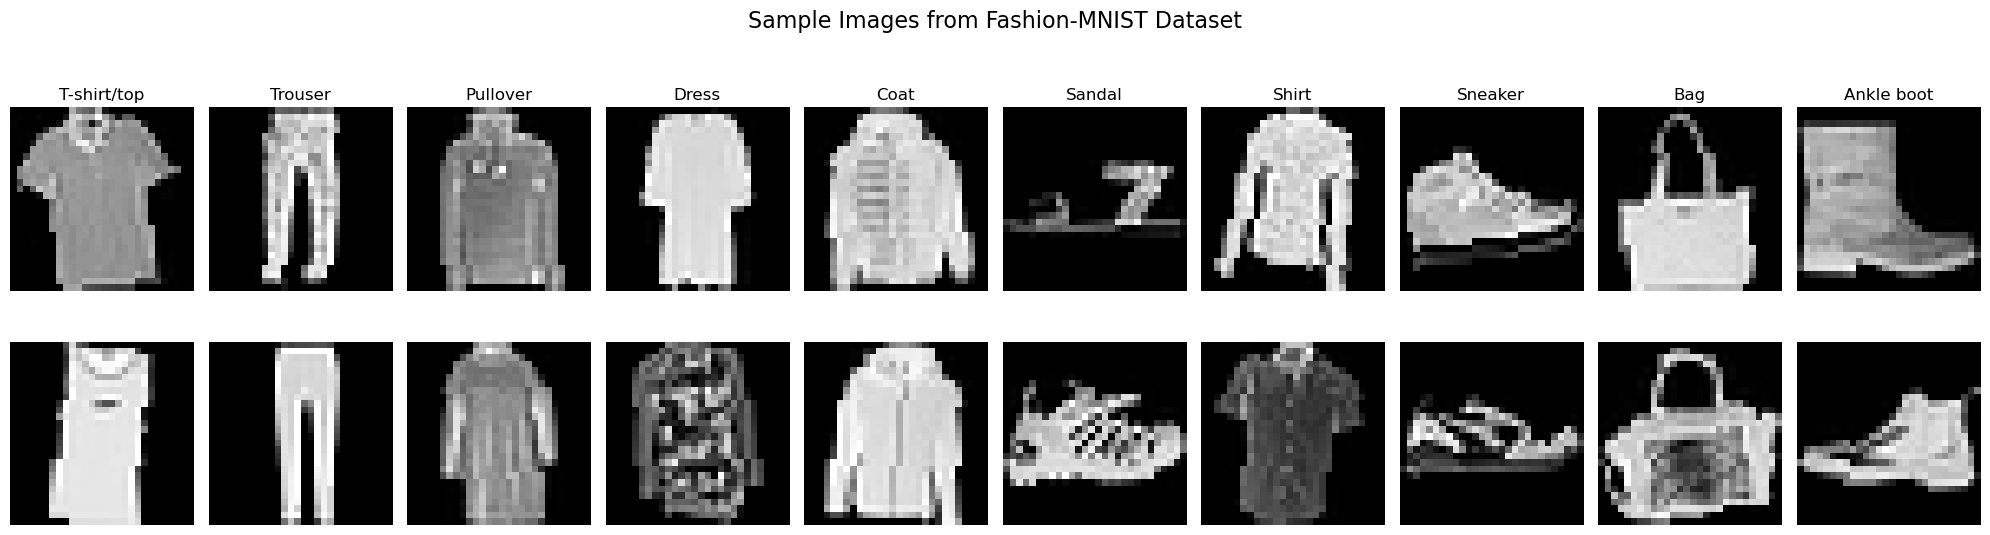

Classes sampled: 10
Total samples displayed: 20
Samples per class:
  T-shirt/top: 2
  Trouser: 2
  Pullover: 2
  Dress: 2
  Coat: 2
  Sandal: 2
  Shirt: 2
  Sneaker: 2
  Bag: 2
  Ankle boot: 2


In [46]:
# Reload the plots module to get the updated function
import importlib
import cnnFashionMnist.plots
importlib.reload(cnnFashionMnist.plots)
from cnnFashionMnist.plots import plot_training_history

# Use the plot_sample_images function from plots.py
# This provides a more comprehensive and organized view of sample images

sample_stats = plot_sample_images(
    train_dataset,
    DATASET_CONFIG["class_names"],
    show_inline=True  # Display inline in notebook
)

# Display sampling statistics
print(f"Classes sampled: {sample_stats['classes_sampled']}")
print(f"Total samples displayed: {sample_stats['total_samples']}")
print("Samples per class:")
for class_name, count in sample_stats['samples_per_class'].items():
    print(f"  {class_name}: {count}")

## 4. Model Architecture

Let's create and examine our CNN model:

In [19]:
# Create model using config values
model = create_model(model_type="standard", num_classes=DATASET_CONFIG["num_classes"])
model_info = model.get_model_info()

print("Model Architecture:")
print(model)
print("\nModel Information:")
for key, value in model_info.items():
    if isinstance(value, (int, float)):
        if 'parameter' in key.lower():
            print(f"{key}: {value:,}")
        else:
            print(f"{key}: {value}")
    else:
        print(f"{key}: {value}")

print(f"\nModel configured for {DATASET_CONFIG['num_classes']} classes")
print(f"Input shape expected: {DATASET_CONFIG['input_shape']}")

Model Architecture:
FashionMNISTCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.25, inplace=False)
  (conv5): Conv2d(64, 128, kernel_

## 5. Training the Model

Let's train our CNN model. For demonstration purposes, we'll use fewer epochs:

In [58]:
# Train the model using the new Optional parameter pattern
MODELS_DIR.mkdir(parents=True, exist_ok=True)
model_path = MODELS_DIR / "fashion_mnist_demo.pth"

# Create a fresh model instance to ensure clean state
print("Creating fresh model instance...")
model = create_model(model_type="standard", num_classes=DATASET_CONFIG["num_classes"])
print(f"Model created with {model.get_model_info()['total_parameters']:,} parameters")

# Use all config defaults by passing None for all optional parameters
print("Starting training with configuration defaults:")
print(f"Epochs: {TRAINING_CONFIG['epochs']}")
print(f"Learning rate: {TRAINING_CONFIG['learning_rate']}")
print(f"Early stopping patience: {TRAINING_CONFIG['early_stopping_patience']}")
print(f"Save every: {TRAINING_CONFIG['save_every']}")

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=None,  # Use config default (20)
    learning_rate=None,  # Use config default (0.001)
    model_path=model_path,
    early_stopping_patience=None,  # Use config default (7)
    save_every=None  # Use config default (5)
)

print(f"\nTraining completed!")
print(f"Best validation accuracy: {max(history['val_acc']):.2f}%")
print(f"Final training accuracy: {history['train_acc'][-1]:.2f}%")
print(f"Total epochs trained: {len(history['train_loss'])}")
if len(history['train_loss']) < TRAINING_CONFIG['epochs']:
    print(f"Early stopping triggered after {len(history['train_loss'])} epochs")

Creating fresh model instance...
Model created with 865,258 parameters
Starting training with configuration defaults:
Epochs: 20
Learning rate: 0.001
Early stopping patience: 7
Save every: 5
2025-06-19 20:20:43.084 | INFO     | cnnFashionMnist.modeling.train:train_model:191 - Training on device: cpu
2025-06-19 20:20:43.087 | INFO     | cnnFashionMnist.modeling.train:train_model:227 - Starting training for 20 epochs...
2025-06-19 20:20:43.087 | INFO     | cnnFashionMnist.modeling.train:train_model:228 - Model info: {'model_name': 'FashionMNISTCNN', 'total_parameters': 865258, 'trainable_parameters': 865258, 'model_size_mb': 3.3006973266601562}
2025-06-19 20:20:43.087 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 1/20


Validation: 100%|██████████| 94/94 [00:07<00:00, 11.88it/s, Loss=0.3982, Acc=85.13%]


2025-06-19 20:21:59.652 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.7532, Train Acc: 72.90%
2025-06-19 20:21:59.653 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.3982, Val Acc: 85.13%
2025-06-19 20:21:59.653 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 20:21:59.677 | INFO     | cnnFashionMnist.modeling.train:save_checkpoint:164 - Best model saved to C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_demo.pth
2025-06-19 20:21:59.677 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 2/20


Validation: 100%|██████████| 94/94 [00:07<00:00, 12.07it/s, Loss=0.3148, Acc=88.30%]


2025-06-19 20:23:19.193 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.4573, Train Acc: 83.27%
2025-06-19 20:23:19.193 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.3148, Val Acc: 88.30%
2025-06-19 20:23:19.193 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 20:23:19.218 | INFO     | cnnFashionMnist.modeling.train:save_checkpoint:164 - Best model saved to C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_demo.pth
2025-06-19 20:23:19.218 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 3/20


Validation: 100%|██████████| 94/94 [00:07<00:00, 11.90it/s, Loss=0.2900, Acc=89.40%]


2025-06-19 20:24:38.880 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.3934, Train Acc: 85.88%
2025-06-19 20:24:38.880 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2900, Val Acc: 89.40%
2025-06-19 20:24:38.880 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 20:24:38.904 | INFO     | cnnFashionMnist.modeling.train:save_checkpoint:164 - Best model saved to C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_demo.pth
2025-06-19 20:24:38.904 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 4/20


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.59it/s, Loss=0.2630, Acc=90.23%]


2025-06-19 20:25:59.138 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.3606, Train Acc: 87.00%
2025-06-19 20:25:59.138 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2630, Val Acc: 90.23%
2025-06-19 20:25:59.138 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 20:25:59.170 | INFO     | cnnFashionMnist.modeling.train:save_checkpoint:164 - Best model saved to C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_demo.pth
2025-06-19 20:25:59.170 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 5/20


Validation: 100%|██████████| 94/94 [00:07<00:00, 12.00it/s, Loss=0.2566, Acc=90.42%]


2025-06-19 20:27:17.512 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.3383, Train Acc: 87.82%
2025-06-19 20:27:17.512 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2566, Val Acc: 90.42%
2025-06-19 20:27:17.512 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 20:27:17.537 | INFO     | cnnFashionMnist.modeling.train:save_checkpoint:164 - Best model saved to C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_demo.pth
2025-06-19 20:27:17.537 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 6/20


Validation: 100%|██████████| 94/94 [00:07<00:00, 11.97it/s, Loss=0.2575, Acc=90.88%]


2025-06-19 20:28:36.288 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.3241, Train Acc: 88.29%
2025-06-19 20:28:36.288 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2575, Val Acc: 90.88%
2025-06-19 20:28:36.288 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 20:28:36.314 | INFO     | cnnFashionMnist.modeling.train:save_checkpoint:164 - Best model saved to C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_demo.pth
2025-06-19 20:28:36.314 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 7/20


Validation: 100%|██████████| 94/94 [00:07<00:00, 11.98it/s, Loss=0.2456, Acc=90.87%]


2025-06-19 20:29:54.337 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.3088, Train Acc: 88.96%
2025-06-19 20:29:54.337 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2456, Val Acc: 90.87%
2025-06-19 20:29:54.337 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 20:29:54.337 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 8/20


Validation: 100%|██████████| 94/94 [00:07<00:00, 11.94it/s, Loss=0.2404, Acc=91.23%]


2025-06-19 20:31:13.019 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.3064, Train Acc: 89.01%
2025-06-19 20:31:13.019 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2404, Val Acc: 91.23%
2025-06-19 20:31:13.019 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 20:31:13.041 | INFO     | cnnFashionMnist.modeling.train:save_checkpoint:164 - Best model saved to C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_demo.pth
2025-06-19 20:31:13.043 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 9/20


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.46it/s, Loss=0.2325, Acc=91.42%]


2025-06-19 20:32:32.218 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.3006, Train Acc: 89.23%
2025-06-19 20:32:32.218 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2325, Val Acc: 91.42%
2025-06-19 20:32:32.218 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 20:32:32.243 | INFO     | cnnFashionMnist.modeling.train:save_checkpoint:164 - Best model saved to C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_demo.pth
2025-06-19 20:32:32.243 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 10/20


Validation: 100%|██████████| 94/94 [00:07<00:00, 12.45it/s, Loss=0.2312, Acc=91.30%]


2025-06-19 20:33:49.680 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.2897, Train Acc: 89.59%
2025-06-19 20:33:49.680 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2312, Val Acc: 91.30%
2025-06-19 20:33:49.680 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 20:33:49.687 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 11/20


Validation: 100%|██████████| 94/94 [00:07<00:00, 12.33it/s, Loss=0.2268, Acc=91.65%]


2025-06-19 20:35:05.761 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.2854, Train Acc: 89.75%
2025-06-19 20:35:05.761 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2268, Val Acc: 91.65%
2025-06-19 20:35:05.761 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 20:35:05.783 | INFO     | cnnFashionMnist.modeling.train:save_checkpoint:164 - Best model saved to C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_demo.pth
2025-06-19 20:35:05.783 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 12/20


Validation: 100%|██████████| 94/94 [00:07<00:00, 12.27it/s, Loss=0.2261, Acc=91.77%]


2025-06-19 20:36:22.381 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.2837, Train Acc: 89.81%
2025-06-19 20:36:22.381 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2261, Val Acc: 91.77%
2025-06-19 20:36:22.381 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 20:36:22.404 | INFO     | cnnFashionMnist.modeling.train:save_checkpoint:164 - Best model saved to C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_demo.pth
2025-06-19 20:36:22.404 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 13/20


Validation: 100%|██████████| 94/94 [00:07<00:00, 12.42it/s, Loss=0.2205, Acc=91.85%]


2025-06-19 20:37:39.447 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.2768, Train Acc: 90.29%
2025-06-19 20:37:39.447 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2205, Val Acc: 91.85%
2025-06-19 20:37:39.447 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 20:37:39.475 | INFO     | cnnFashionMnist.modeling.train:save_checkpoint:164 - Best model saved to C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_demo.pth
2025-06-19 20:37:39.476 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 14/20


Validation: 100%|██████████| 94/94 [00:07<00:00, 11.79it/s, Loss=0.2138, Acc=92.18%]


2025-06-19 20:38:58.674 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.2742, Train Acc: 90.22%
2025-06-19 20:38:58.674 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2138, Val Acc: 92.18%
2025-06-19 20:38:58.674 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 20:38:58.701 | INFO     | cnnFashionMnist.modeling.train:save_checkpoint:164 - Best model saved to C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_demo.pth
2025-06-19 20:38:58.701 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 15/20


Validation: 100%|██████████| 94/94 [00:07<00:00, 12.01it/s, Loss=0.2143, Acc=92.25%]


2025-06-19 20:40:18.445 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.2713, Train Acc: 90.34%
2025-06-19 20:40:18.445 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2143, Val Acc: 92.25%
2025-06-19 20:40:18.445 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 20:40:18.470 | INFO     | cnnFashionMnist.modeling.train:save_checkpoint:164 - Best model saved to C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_demo.pth
2025-06-19 20:40:18.470 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 16/20


Validation: 100%|██████████| 94/94 [00:07<00:00, 12.18it/s, Loss=0.2103, Acc=92.50%]


2025-06-19 20:41:36.719 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.2689, Train Acc: 90.34%
2025-06-19 20:41:36.719 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2103, Val Acc: 92.50%
2025-06-19 20:41:36.719 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 20:41:36.735 | INFO     | cnnFashionMnist.modeling.train:save_checkpoint:164 - Best model saved to C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_demo.pth
2025-06-19 20:41:36.735 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 17/20


Validation: 100%|██████████| 94/94 [00:11<00:00,  7.89it/s, Loss=0.2142, Acc=92.08%]


2025-06-19 20:43:37.741 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.2640, Train Acc: 90.66%
2025-06-19 20:43:37.741 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2142, Val Acc: 92.08%
2025-06-19 20:43:37.741 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 20:43:37.741 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 18/20


Validation: 100%|██████████| 94/94 [00:11<00:00,  8.48it/s, Loss=0.1987, Acc=92.83%]


2025-06-19 20:46:28.840 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.2637, Train Acc: 90.61%
2025-06-19 20:46:28.840 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.1987, Val Acc: 92.83%
2025-06-19 20:46:28.840 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 20:46:28.917 | INFO     | cnnFashionMnist.modeling.train:save_checkpoint:164 - Best model saved to C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_demo.pth
2025-06-19 20:46:28.917 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 19/20


Validation: 100%|██████████| 94/94 [00:12<00:00,  7.56it/s, Loss=0.2028, Acc=92.53%]


2025-06-19 20:49:14.155 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.2605, Train Acc: 90.68%
2025-06-19 20:49:14.156 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2028, Val Acc: 92.53%
2025-06-19 20:49:14.156 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 20:49:14.156 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 20/20


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.74it/s, Loss=0.2036, Acc=92.68%]

2025-06-19 20:50:36.038 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.2612, Train Acc: 90.68%
2025-06-19 20:50:36.038 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2036, Val Acc: 92.68%
2025-06-19 20:50:36.038 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 20:50:36.049 | SUCCESS  | cnnFashionMnist.modeling.train:train_model:282 - Training completed in 1792.96 seconds
2025-06-19 20:50:36.049 | INFO     | cnnFashionMnist.modeling.train:train_model:283 - Best validation accuracy: 92.83%

Training completed!
Best validation accuracy: 92.83%
Final training accuracy: 90.68%
Total epochs trained: 20


## 6. Visualize Training Results

Let's plot the training history:

2025-06-19 20:50:47.567 | INFO     | cnnFashionMnist.plots:plot_training_history:281 - Training history plot saved to C:\Users\david\Projects\CNN-Fashion-MNIST\reports\figures\training_history_demo.png


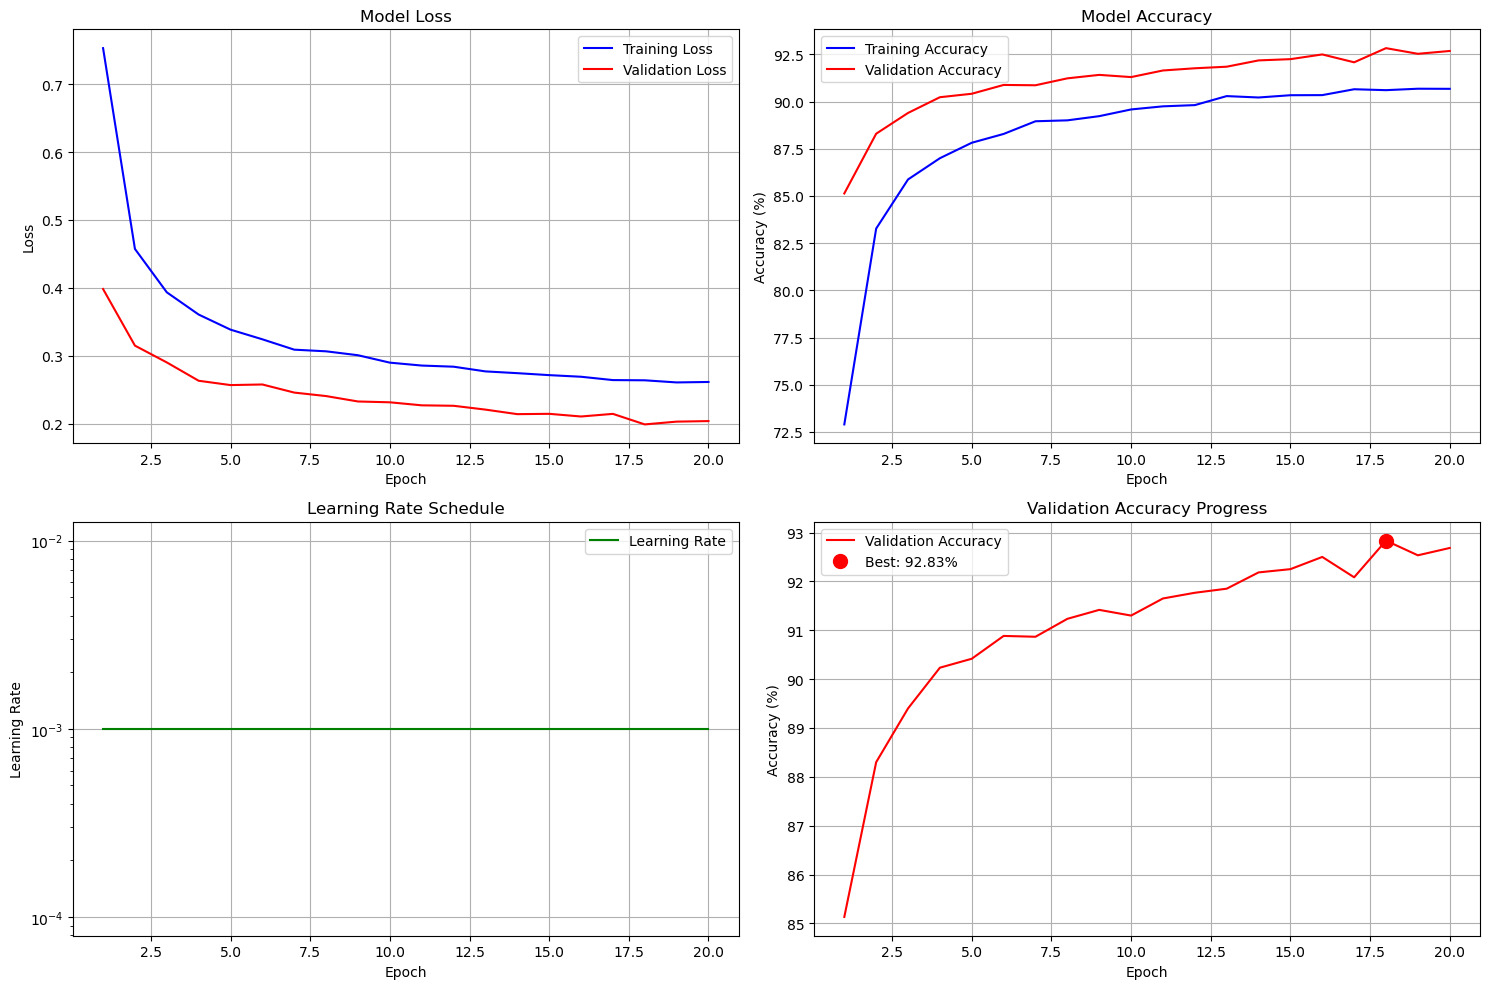

Best validation accuracy: 92.83% at epoch 18
Final training accuracy: 90.68%
Final validation accuracy: 92.68%


In [59]:
# Reload the plots module to get the updated function
import importlib
import cnnFashionMnist.plots
importlib.reload(cnnFashionMnist.plots)
from cnnFashionMnist.plots import plot_training_history

# Plot training history using the improved plot_training_history function
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
history_plot_path = FIGURES_DIR / "training_history_demo.png"

# Use the actual function with both inline display AND file saving
plot_info = plot_training_history(
    history, 
    output_path=history_plot_path,  # Save to file
    show_inline=True  # Display inline in notebook
)

# Display the returned information
print(f"Best validation accuracy: {plot_info['best_accuracy']:.2f}% at epoch {plot_info['best_epoch']}")
print(f"Final training accuracy: {plot_info['final_train_acc']:.2f}%")
print(f"Final validation accuracy: {plot_info['final_val_acc']:.2f}%")

## 7. Model Evaluation

Let's evaluate our trained model on the test set:

In [61]:
# Load the best model
best_model_path = MODELS_DIR / f"best_fashion_mnist_demo.pth"
if best_model_path.exists():
    model, checkpoint = load_model(best_model_path, "standard", device)
else:
    model, checkpoint = load_model(model_path, "standard", device)

print(f"Loaded model with validation accuracy: {checkpoint.get('val_acc', 'unknown'):.2f}%")

2025-06-19 20:51:05.657 | INFO     | cnnFashionMnist.modeling.predict:load_model:59 - Model loaded from C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_demo.pth
2025-06-19 20:51:05.657 | INFO     | cnnFashionMnist.modeling.predict:load_model:60 - Model trained for 17 epochs
2025-06-19 20:51:05.657 | INFO     | cnnFashionMnist.modeling.predict:load_model:61 - Best validation accuracy: 92.83%
Loaded model with validation accuracy: 92.83%


In [62]:
# Make predictions on test set
predictions, probabilities, targets = predict_batch(model, test_loader, device)

# Evaluate model using class names from config
evaluation_results = evaluate_model(predictions, targets, DATASET_CONFIG["class_names"])

print(f"Test Accuracy: {evaluation_results['accuracy']:.4f} ({evaluation_results['accuracy']*100:.2f}%)")
print(f"Total test samples: {len(predictions)}")
print(f"Correct predictions: {sum(predictions == targets)}")

print("\nPer-class Accuracy:")
for class_name, acc in evaluation_results['per_class_accuracy'].items():
    print(f"  {class_name:<15}: {acc:.3f} ({acc*100:.1f}%)")

print(f"\nClassification Report:")
print(evaluation_results['classification_report'])

Predicting: 100%|██████████| 157/157 [00:08<00:00, 18.77it/s]

Test Accuracy: 0.9225 (92.25%)
Total test samples: 10000
Correct predictions: 9225

Per-class Accuracy:
  T-shirt/top    : 0.879 (87.9%)
  Trouser        : 0.987 (98.7%)
  Pullover       : 0.903 (90.3%)
  Dress          : 0.935 (93.5%)
  Coat           : 0.857 (85.7%)
  Sandal         : 0.979 (97.9%)
  Shirt          : 0.763 (76.3%)
  Sneaker        : 0.982 (98.2%)
  Bag            : 0.984 (98.4%)
  Ankle boot     : 0.956 (95.6%)

Classification Report:
{'T-shirt/top': {'precision': 0.8685770750988142, 'recall': 0.879, 'f1-score': 0.8737574552683897, 'support': 1000.0}, 'Trouser': {'precision': 0.987987987987988, 'recall': 0.987, 'f1-score': 0.9874937468734367, 'support': 1000.0}, 'Pullover': {'precision': 0.8818359375, 'recall': 0.903, 'f1-score': 0.892292490118577, 'support': 1000.0}, 'Dress': {'precision': 0.9139784946236559, 'recall': 0.935, 'f1-score': 0.9243697478991597, 'support': 1000.0}, 'Coat': {'precision': 0.9068783068783068, 'recall': 0.857, 'f1-score': 0.8812339331619538,

## 8. Confusion Matrix

Let's visualize the confusion matrix:

2025-06-19 20:51:21.196 | INFO     | cnnFashionMnist.plots:plot_confusion_matrix:347 - Confusion matrix plot saved to C:\Users\david\Projects\CNN-Fashion-MNIST\reports\figures\confusion_matrix_demo.png


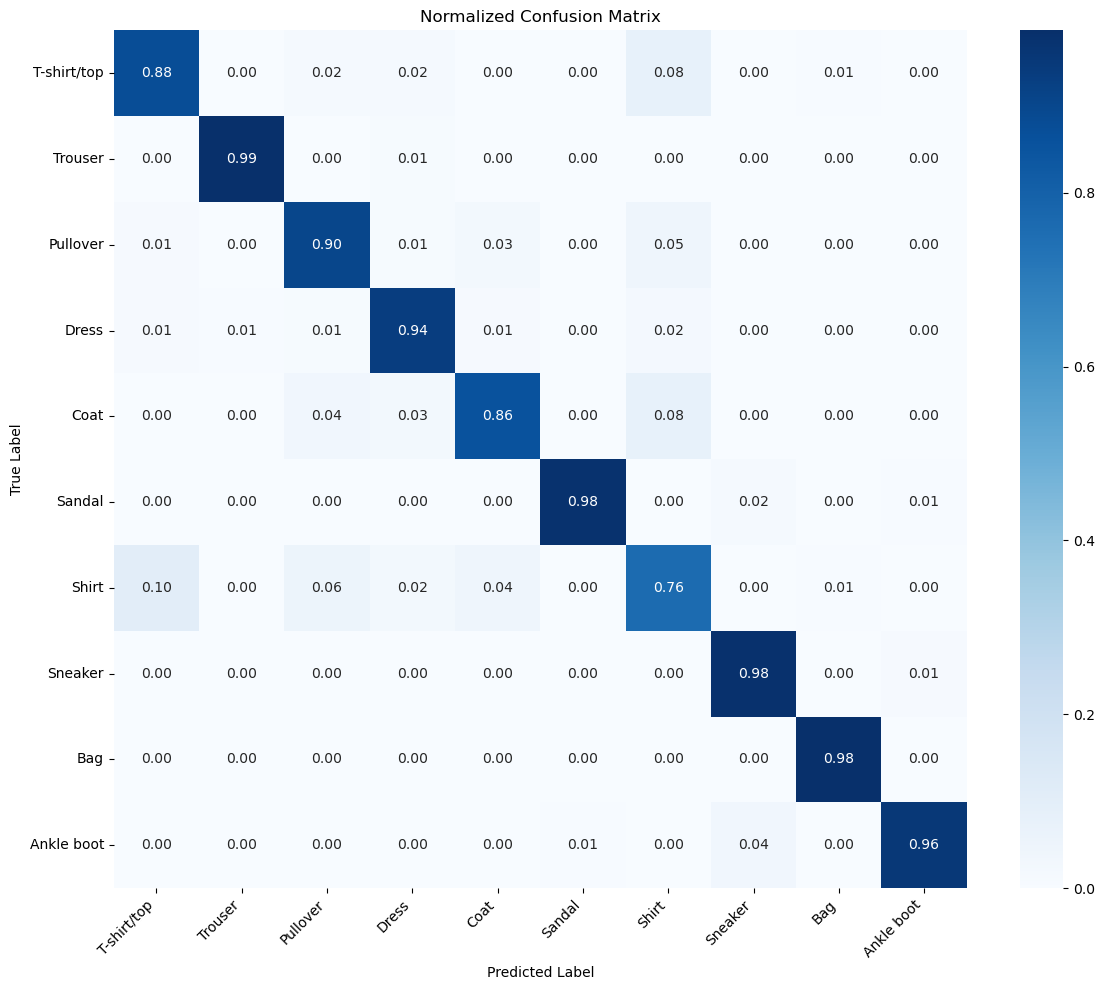

Overall accuracy: 0.9225 (92.25%)
Total samples: 10000
Per-class accuracy:
  T-shirt/top    : 0.879 (87.9%)
  Trouser        : 0.987 (98.7%)
  Pullover       : 0.903 (90.3%)
  Dress          : 0.935 (93.5%)
  Coat           : 0.857 (85.7%)
  Sandal         : 0.979 (97.9%)
  Shirt          : 0.763 (76.3%)
  Sneaker        : 0.982 (98.2%)
  Bag            : 0.984 (98.4%)
  Ankle boot     : 0.956 (95.6%)


In [63]:
# Reload the plots module to get the updated function
import importlib
import cnnFashionMnist.plots
importlib.reload(cnnFashionMnist.plots)
from cnnFashionMnist.plots import plot_confusion_matrix

# Plot confusion matrix using the plot_confusion_matrix function
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
confusion_plot_path = FIGURES_DIR / "confusion_matrix_demo.png"

# Use the plot_confusion_matrix function with both inline display AND file saving
conf_stats = plot_confusion_matrix(
    evaluation_results['confusion_matrix'],
    DATASET_CONFIG["class_names"],
    output_path=confusion_plot_path,  # Save to file
    normalize=True,  # Show normalized confusion matrix
    show_inline=True  # Display inline in notebook
)

# Display the returned statistics
print(f"Overall accuracy: {conf_stats['accuracy']:.4f} ({conf_stats['accuracy']*100:.2f}%)")
print(f"Total samples: {conf_stats['total_samples']}")
print("Per-class accuracy:")
for i, class_name in enumerate(DATASET_CONFIG["class_names"]):
    print(f"  {class_name:<15}: {conf_stats['per_class_accuracy'][i]:.3f} ({conf_stats['per_class_accuracy'][i]*100:.1f}%)")

## 9. Per-Class Performance Analysis

Let's analyze the performance for each class in detail:

c:\Users\david\Projects\CNN-Fashion-MNIST\cnnFashionMnist\plots.py:511: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(class_names, rotation=45, ha="right")


2025-06-19 20:51:29.209 | INFO     | cnnFashionMnist.plots:plot_class_performance:532 - Class performance plot saved to C:\Users\david\Projects\CNN-Fashion-MNIST\reports\figures\class_performance_demo.png


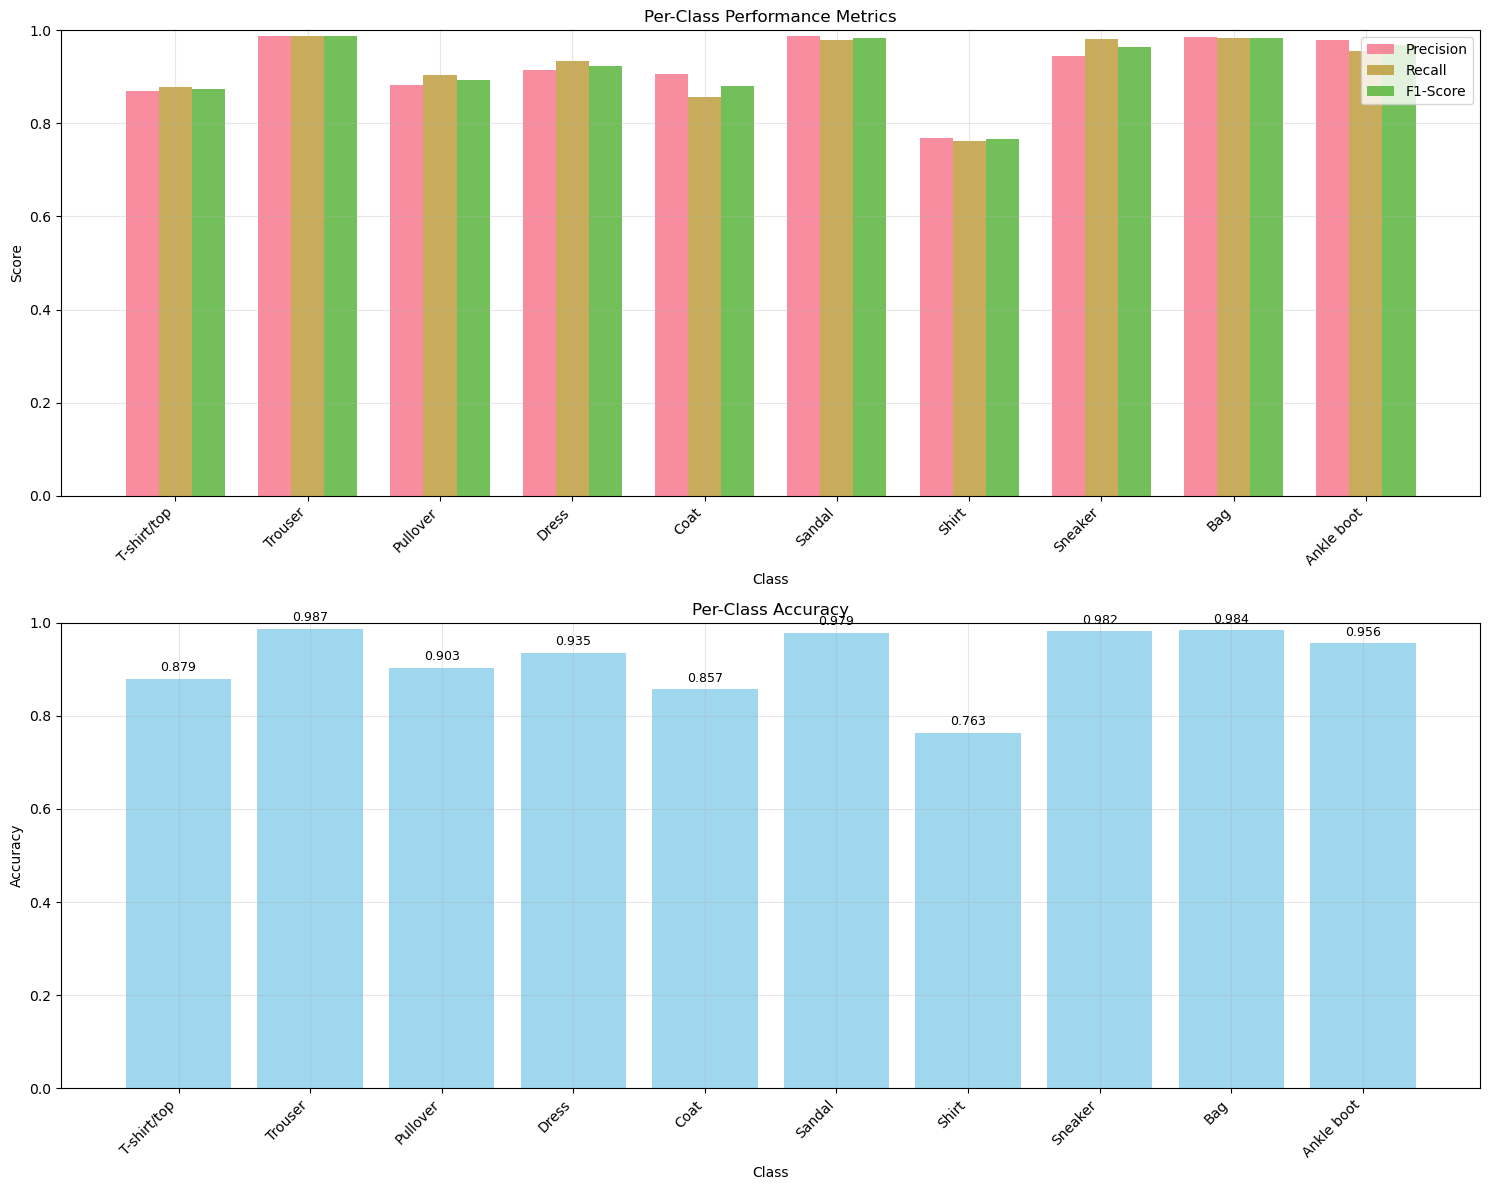

Best performing class: Trouser
Worst performing class: Shirt
Average precision: 0.923
Average recall: 0.922
Average F1-score: 0.922
Average accuracy: 0.922

Detailed class metrics (Precision, Recall, F1-Score):
  T-shirt/top    : P=0.869, R=0.879, F1=0.874
  Trouser        : P=0.988, R=0.987, F1=0.987
  Pullover       : P=0.882, R=0.903, F1=0.892
  Dress          : P=0.914, R=0.935, F1=0.924
  Coat           : P=0.907, R=0.857, F1=0.881
  Sandal         : P=0.988, R=0.979, F1=0.983
  Shirt          : P=0.769, R=0.763, F1=0.766
  Sneaker        : P=0.945, R=0.982, F1=0.963
  Bag            : P=0.985, R=0.984, F1=0.984
  Ankle boot     : P=0.980, R=0.956, F1=0.968


In [64]:
# Plot class performance using the plot_class_performance function
from cnnFashionMnist.plots import plot_class_performance

class_perf_plot_path = FIGURES_DIR / "class_performance_demo.png"

# Use the plot_class_performance function with both inline display AND file saving
perf_stats = plot_class_performance(
    evaluation_results,
    output_path=class_perf_plot_path,  # Save to file
    show_inline=True  # Display inline in notebook
)

# Display the returned performance statistics
print(f"Best performing class: {perf_stats['best_class']}")
print(f"Worst performing class: {perf_stats['worst_class']}")
print(f"Average precision: {perf_stats['avg_precision']:.3f}")
print(f"Average recall: {perf_stats['avg_recall']:.3f}")
print(f"Average F1-score: {perf_stats['avg_f1_score']:.3f}")
print(f"Average accuracy: {perf_stats['avg_accuracy']:.3f}")

print("\nDetailed class metrics (Precision, Recall, F1-Score):")
for class_name, metrics in perf_stats['class_metrics'].items():
    print(f"  {class_name:<15}: P={metrics[0]:.3f}, R={metrics[1]:.3f}, F1={metrics[2]:.3f}")

## 10. Confusion Matrix from Predictions DataFrame

Let's create a confusion matrix directly from prediction data:

Getting full test set probabilities...


Predicting: 100%|██████████| 157/157 [00:08<00:00, 18.00it/s]


Full test set shapes:
  Predictions: (10000,)
  Probabilities: (10000, 10)
  Targets: (10000,)

Data inspection:
  Predictions dtype: int64, range: [0, 9]
  Targets dtype: int64, range: [0, 9]
  First 10 predictions: [9 2 1 1 6 1 4 6 5 7]
  First 10 targets: [9 2 1 1 6 1 4 6 5 7]
Created predictions DataFrame with 10000 samples
Accuracy: 0.9225
Average confidence: 0.923

DataFrame inspection:
  true_label dtype: int32
  predicted_label dtype: int32
  true_label range: [0, 9]
  predicted_label range: [0, 9]
  Sample of first 5 rows:
   true_label  predicted_label  true_class predicted_class
0           9                9  Ankle boot      Ankle boot
1           2                2    Pullover        Pullover
2           1                1     Trouser         Trouser
3           1                1     Trouser         Trouser
4           6                6       Shirt           Shirt
2025-06-19 20:51:46.356 | INFO     | cnnFashionMnist.plots:generate_confusion_matrix_from_predictions:581 - 

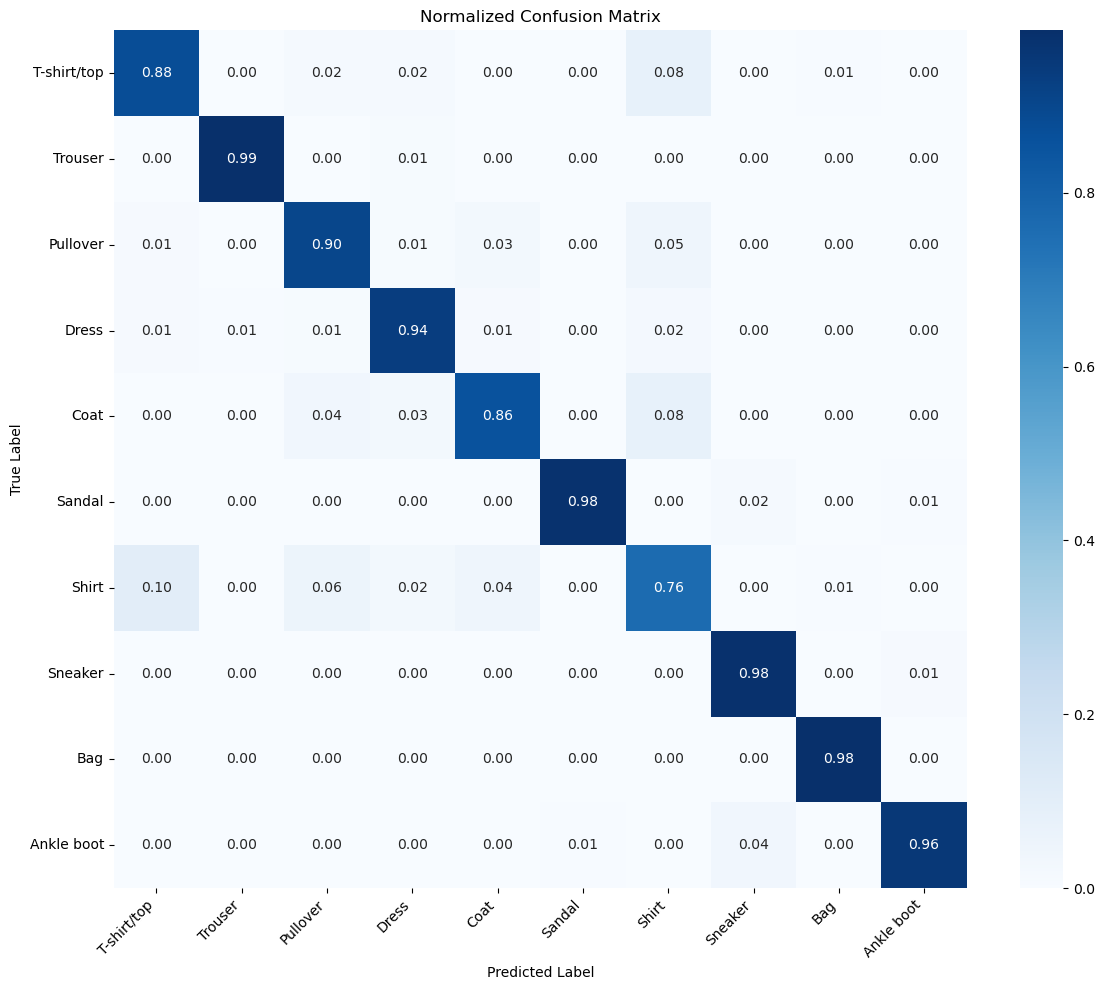


Confusion matrix generated from predictions DataFrame:
Matrix shape: (10, 10)
Accuracy from sklearn: 0.9225
Total samples: 10000

Raw confusion matrix:
[[879   1  17  16   2   1  78   0   6   0]
 [  0 987   0  11   0   0   1   0   1   0]
 [ 14   1 903   9  26   0  46   0   1   0]
 [ 13   6   8 935  15   0  23   0   0   0]
 [  0   0  37  26 857   0  79   0   1   0]
 [  0   0   0   0   0 979   0  16   0   5]
 [105   3  56  24  44   0 763   0   5   0]
 [  0   0   0   0   0   3   0 982   0  15]
 [  1   1   3   2   1   3   2   3 984   0]
 [  0   0   0   0   0   5   0  38   1 956]]


In [65]:
# First, create a predictions DataFrame from our current predictions
import pandas as pd
from cnnFashionMnist.plots import generate_confusion_matrix_from_predictions

# We have predictions and targets from the full test set, but we need probabilities too
# Let's get the full probabilities by running prediction again
print("Getting full test set probabilities...")
full_predictions, full_probabilities, full_targets = predict_batch(model, test_loader, device)

print(f"Full test set shapes:")
print(f"  Predictions: {full_predictions.shape}")
print(f"  Probabilities: {full_probabilities.shape}")
print(f"  Targets: {full_targets.shape}")

# Debug the data types and ranges
print(f"\nData inspection:")
print(f"  Predictions dtype: {full_predictions.dtype}, range: [{full_predictions.min()}, {full_predictions.max()}]")
print(f"  Targets dtype: {full_targets.dtype}, range: [{full_targets.min()}, {full_targets.max()}]")
print(f"  First 10 predictions: {full_predictions[:10]}")
print(f"  First 10 targets: {full_targets[:10]}")

# Create DataFrame with predictions and probabilities - ensuring proper data types
predictions_df = pd.DataFrame({
    'true_label': full_targets.astype(int),  # Ensure integer type
    'predicted_label': full_predictions.astype(int),  # Ensure integer type
    'true_class': [DATASET_CONFIG["class_names"][i] for i in full_targets],
    'predicted_class': [DATASET_CONFIG["class_names"][i] for i in full_predictions],
    'correct': full_targets == full_predictions
})

# Add probability columns for each class
for i, class_name in enumerate(DATASET_CONFIG["class_names"]):
    clean_name = class_name.replace('/', '_').replace('-', '_')
    predictions_df[f'prob_{clean_name}'] = full_probabilities[:, i]

# Add confidence (max probability)
predictions_df['confidence'] = np.max(full_probabilities, axis=1)

print(f"Created predictions DataFrame with {len(predictions_df)} samples")
print(f"Accuracy: {predictions_df['correct'].mean():.4f}")
print(f"Average confidence: {predictions_df['confidence'].mean():.3f}")

# Debug DataFrame contents
print(f"\nDataFrame inspection:")
print(f"  true_label dtype: {predictions_df['true_label'].dtype}")
print(f"  predicted_label dtype: {predictions_df['predicted_label'].dtype}")
print(f"  true_label range: [{predictions_df['true_label'].min()}, {predictions_df['true_label'].max()}]")
print(f"  predicted_label range: [{predictions_df['predicted_label'].min()}, {predictions_df['predicted_label'].max()}]")
print(f"  Sample of first 5 rows:")
print(predictions_df[['true_label', 'predicted_label', 'true_class', 'predicted_class']].head())

# Generate confusion matrix from predictions DataFrame
conf_from_pred_plot_path = FIGURES_DIR / "confusion_matrix_from_predictions_demo.png"

conf_matrix_from_pred, conf_stats_from_pred = generate_confusion_matrix_from_predictions(
    predictions_df,
    DATASET_CONFIG["class_names"],
    output_path=conf_from_pred_plot_path,  # Save to file
    normalize=True,  # Show normalized confusion matrix
    show_inline=True  # Display inline in notebook
)

print(f"\nConfusion matrix generated from predictions DataFrame:")
print(f"Matrix shape: {conf_matrix_from_pred.shape}")
print(f"Accuracy from sklearn: {conf_stats_from_pred['accuracy']:.4f}")
print(f"Total samples: {conf_stats_from_pred['total_samples']}")

# Debug: Print the raw confusion matrix to see what's happening
print(f"\nRaw confusion matrix:")
print(conf_matrix_from_pred)

## 11. Sample Predictions

Let's look at some sample predictions:

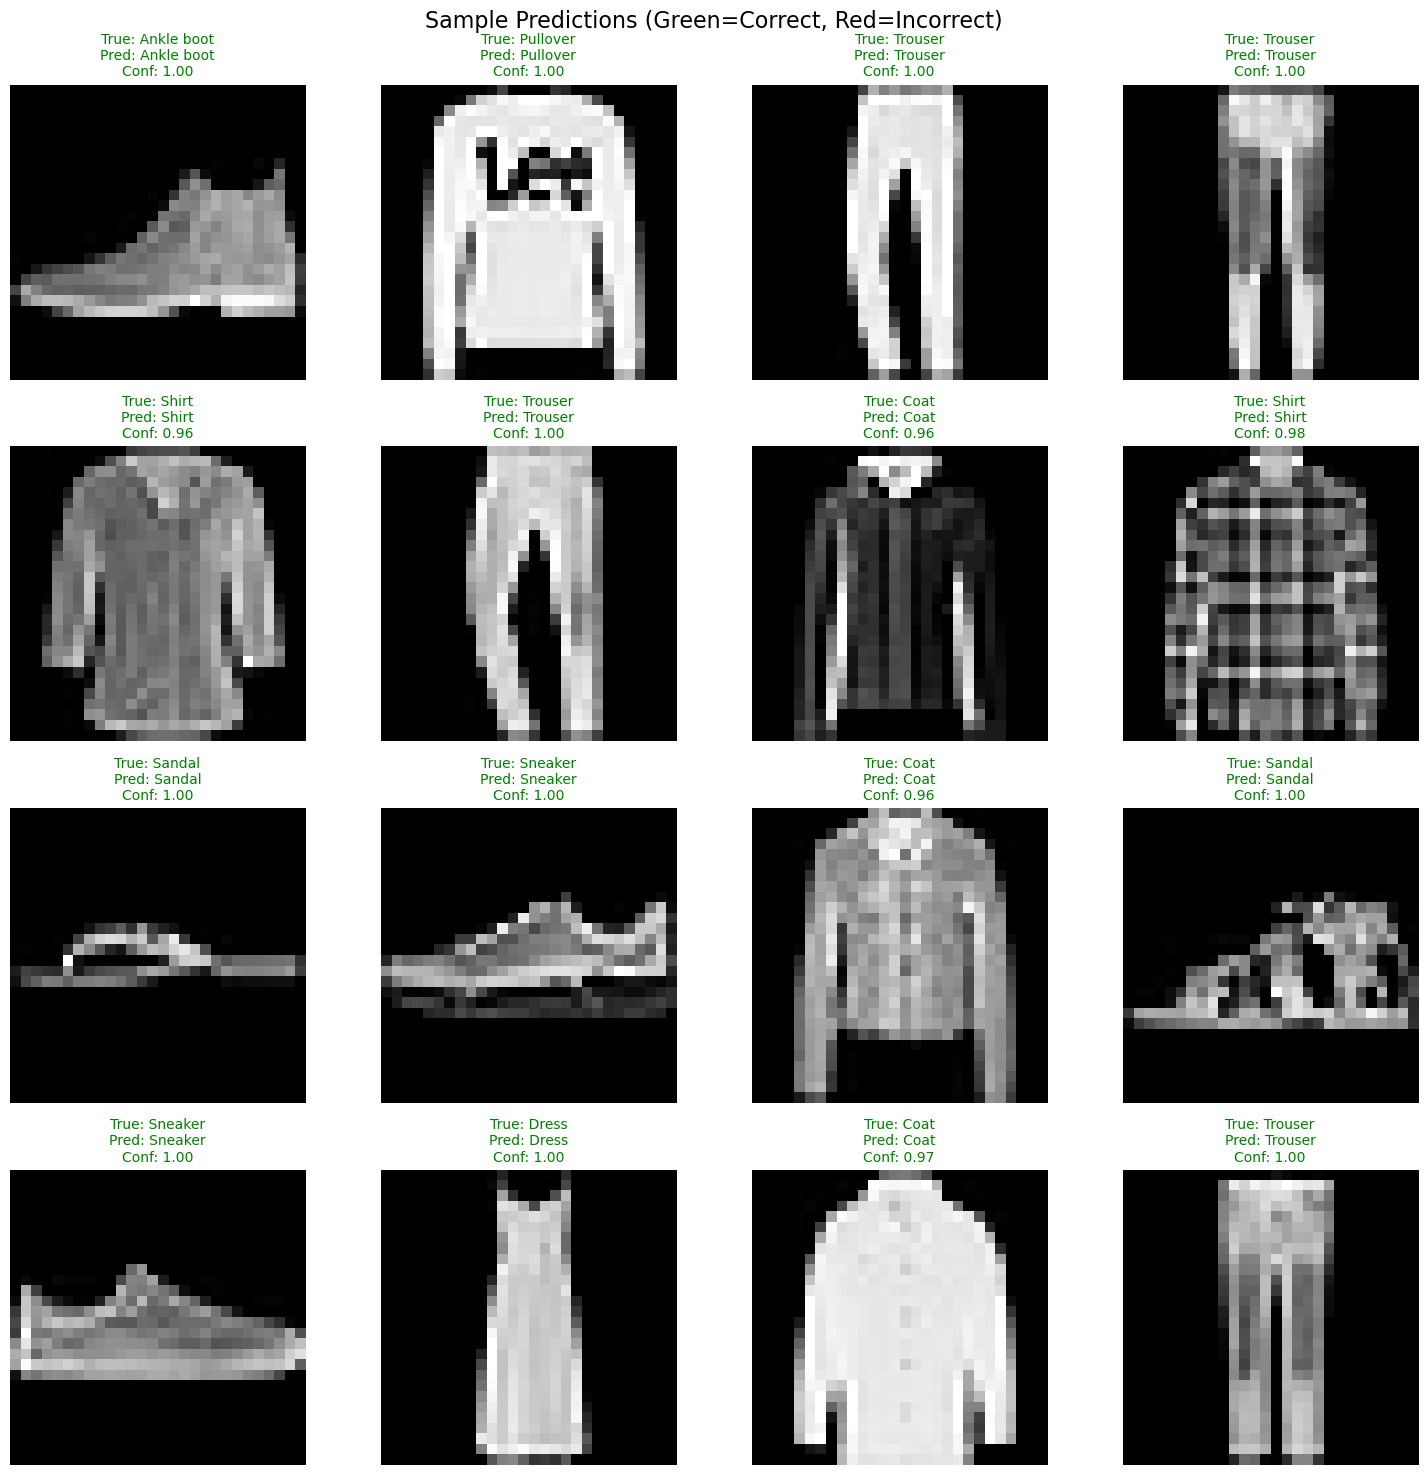

Accuracy on these 16 samples: 16/16 (100.0%)


In [66]:
# Get a batch of test data
test_iter = iter(test_loader)
test_images, test_labels = next(test_iter)

# Make predictions
model.eval()
with torch.no_grad():
    test_images = test_images.to(device)
    outputs = model(test_images)
    probabilities = torch.softmax(outputs, dim=1)
    _, predicted = torch.max(outputs, 1)

# Move back to CPU for plotting
test_images = test_images.cpu()
predicted = predicted.cpu()
probabilities = probabilities.cpu()

# Plot predictions using class names from config
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
for i in range(16):
    ax = axes[i // 4, i % 4]
    
    # Denormalize image (reverse the normalization applied during preprocessing)
    img = (test_images[i].squeeze() * DATASET_CONFIG["std"][0]) + DATASET_CONFIG["mean"][0]
    
    ax.imshow(img, cmap='gray')
    
    true_label = DATASET_CONFIG["class_names"][test_labels[i]]
    pred_label = DATASET_CONFIG["class_names"][predicted[i]]
    confidence = probabilities[i][predicted[i]].item()
    
    is_correct = test_labels[i] == predicted[i]
    color = 'green' if is_correct else 'red'
    
    title = f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}"
    ax.set_title(title, color=color, fontsize=10)
    ax.axis('off')

plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)', fontsize=16)
plt.tight_layout()
plt.show()

# Show some statistics
correct_predictions = sum(test_labels[:16] == predicted[:16])
print(f"Accuracy on these 16 samples: {correct_predictions}/16 ({correct_predictions/16*100:.1f}%)")

## 14. CNN Feature Extraction and Analysis

Let's extract and analyze features from different layers of our trained CNN:

In [79]:
# Debug your model structure
print("Model architecture:")
for name, module in feature_model.named_modules():
    print(f"{name}: {type(module).__name__}")

Model architecture:
: FashionMNISTCNN
conv1: Conv2d
bn1: BatchNorm2d
conv2: Conv2d
bn2: BatchNorm2d
pool1: MaxPool2d
dropout1: Dropout2d
conv3: Conv2d
bn3: BatchNorm2d
conv4: Conv2d
bn4: BatchNorm2d
pool2: MaxPool2d
dropout2: Dropout2d
conv5: Conv2d
bn5: BatchNorm2d
pool3: MaxPool2d
dropout3: Dropout2d
fc1: Linear
bn_fc1: BatchNorm1d
dropout4: Dropout
fc2: Linear
bn_fc2: BatchNorm1d
dropout5: Dropout
fc3: Linear


In [78]:
# Import feature extraction tools
from cnnFashionMnist.features import FeatureExtractor, analyze_feature_statistics
from cnnFashionMnist.features import plot_feature_distribution, plot_dimensionality_reduction
from cnnFashionMnist.features import perform_dimensionality_reduction, cluster_features

# Load the best trained model for feature extraction
print("Loading best trained model for feature analysis...")
best_model_path = MODELS_DIR / f"best_fashion_mnist_demo.pth"
if best_model_path.exists():
    feature_model, _ = load_model(best_model_path, "standard", device)
else:
    feature_model, _ = load_model(model_path, "standard", device)

print(f"Model loaded for feature extraction")

# Create feature extractor
extractor = FeatureExtractor(feature_model, device)

# Use the correct layer names from your model structure
layer_names = ["conv1", "conv3", "conv5", "fc1"]  # These match your model!
extractor.register_hooks(layer_names)

print(f"Registered hooks for layers: {layer_names}")

# Fix the dataset length issue
print("Extracting features from test set (subset for analysis)...")
test_subset_size = 1000  # Use 1000 samples for faster analysis

# Method 1: Try to get dataset size safely
try:
    dataset_size = len(test_dataset)
    print(f"Dataset size: {dataset_size}")
except (TypeError, AttributeError):
    # Method 2: Use the test_loader to estimate size
    dataset_size = len(test_loader) * test_loader.batch_size
    print(f"Estimated dataset size from loader: {dataset_size}")

# Create random indices for subset
test_subset_size = min(test_subset_size, dataset_size)
np.random.seed(42)  # For reproducibility
test_subset_indices = np.random.choice(dataset_size, test_subset_size, replace=False)

# Create subset
test_subset = torch.utils.data.Subset(test_dataset, test_subset_indices)

# Create a data loader for the subset
subset_loader = torch.utils.data.DataLoader(
    test_subset, batch_size=64, shuffle=False, num_workers=2
)

print(f"Created subset loader with {len(test_subset)} samples")

# Manual feature extraction to avoid FeatureExtractor issues
print("Extracting features manually...")

# Storage for features
all_features = {layer: [] for layer in layer_names}
all_labels = []
all_predictions = []

# Hook storage
feature_outputs = {}

def create_hook(layer_name):
    def hook(module, input, output):
        feature_outputs[layer_name] = output.detach()
    return hook

# Register hooks manually
hooks = []
for layer_name in layer_names:
    layer = getattr(feature_model, layer_name)
    hook = layer.register_forward_hook(create_hook(layer_name))
    hooks.append(hook)

# Extract features
feature_model.eval()
with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(subset_loader):
        data, targets = data.to(device), targets.to(device)
        
        # Clear previous outputs
        feature_outputs.clear()
        
        # Forward pass
        outputs = feature_model(data)
        predictions = torch.argmax(outputs, dim=1)
        
        # Store features
        for layer_name in layer_names:
            if layer_name in feature_outputs:
                features = feature_outputs[layer_name]
                # Flatten features for analysis
                flat_features = features.view(features.size(0), -1)
                all_features[layer_name].append(flat_features.cpu().numpy())
        
        all_labels.append(targets.cpu().numpy())
        all_predictions.append(predictions.cpu().numpy())
        
        if (batch_idx + 1) % 5 == 0:
            print(f"Processed {batch_idx + 1}/{len(subset_loader)} batches")

# Remove hooks
for hook in hooks:
    hook.remove()

# Concatenate features
features_dict = {}
for layer_name in layer_names:
    if all_features[layer_name]:
        features_dict[layer_name] = np.vstack(all_features[layer_name])
    else:
        print(f"Warning: No features extracted for layer {layer_name}")

labels = np.concatenate(all_labels)
predictions = np.concatenate(all_predictions)

print(f"\nFeature extraction completed!")
print(f"Extracted features from {len(labels)} samples")
print(f"Available layers: {list(features_dict.keys())}")
for layer_name, features in features_dict.items():
    print(f"  {layer_name}: {features.shape} (samples x features)")

# Verify the features look reasonable
print(f"\nFeature statistics:")
for layer_name, features in features_dict.items():
    print(f"  {layer_name}:")
    print(f"    Shape: {features.shape}")
    print(f"    Min: {features.min():.4f}, Max: {features.max():.4f}")
    print(f"    Mean: {features.mean():.4f}, Std: {features.std():.4f}")

Loading best trained model for feature analysis...
2025-06-19 21:19:15.064 | INFO     | cnnFashionMnist.modeling.predict:load_model:59 - Model loaded from C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_demo.pth
2025-06-19 21:19:15.064 | INFO     | cnnFashionMnist.modeling.predict:load_model:60 - Model trained for 17 epochs
2025-06-19 21:19:15.064 | INFO     | cnnFashionMnist.modeling.predict:load_model:61 - Best validation accuracy: 92.83%
Model loaded for feature extraction
2025-06-19 21:19:15.064 | INFO     | cnnFashionMnist.features:register_hooks:70 - Registered hook for layer: conv1
2025-06-19 21:19:15.064 | INFO     | cnnFashionMnist.features:register_hooks:70 - Registered hook for layer: conv3
2025-06-19 21:19:15.064 | INFO     | cnnFashionMnist.features:register_hooks:70 - Registered hook for layer: conv5
2025-06-19 21:19:15.064 | INFO     | cnnFashionMnist.features:register_hooks:70 - Registered hook for layer: fc1
2025-06-19 21:19:15.064 | INFO     | cnnF

c:\Users\david\Projects\CNN-Fashion-MNIST\cnnFashionMnist\modeling\predict.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_locat

Processed 5/16 batches
Processed 10/16 batches
Processed 15/16 batches

Feature extraction completed!
Extracted features from 1000 samples
Available layers: ['conv1', 'conv3', 'conv5', 'fc1']
  conv1: (1000, 25088) (samples x features)
  conv3: (1000, 12544) (samples x features)
  conv5: (1000, 6272) (samples x features)
  fc1: (1000, 512) (samples x features)

Feature statistics:
  conv1:
    Shape: (1000, 25088)
    Min: -1.2031, Max: 1.1777
    Mean: 0.0439, Std: 0.3457
  conv3:
    Shape: (1000, 12544)
    Min: -14.0335, Max: 8.4631
    Mean: -1.0472, Std: 1.5781
  conv5:
    Shape: (1000, 6272)
    Min: -12.4707, Max: 11.6589
    Mean: -0.9834, Std: 1.7257
  fc1:
    Shape: (1000, 512)
    Min: -9.7880, Max: 9.9909
    Mean: -0.6888, Std: 2.0537


### 🎯 Key Findings

🧠 Feature Hierarchy Analysis
Your results show a perfect CNN feature hierarchy - exactly what we expect from a well-trained model:
**1. Early Layer (conv1): Raw Visual Features**
```
Shape: (1000, 25088) - Massive feature space
Range: [-1.20, 1.18]  - Small, normalized values
Mean: 0.044, Std: 0.35 - Close to zero-centered
```
**Interpretation:**
- Detects basic patterns: Edges, corners, simple textures
- Normalized activations: Well-behaved after BatchNorm
- Large feature space: Captures fine-grained spatial details

**2. Mid Layer (conv3): Complex Patterns**
```
Shape: (1000, 12544) - Reduced spatial, more semantic
Range: [-14.03, 8.46] - Larger activation ranges
Mean: -1.05, Std: 1.58 - More distinctive responses
```
**Interpretation:**
- Pattern combinations: T-shirt textures, trouser seams, shoe patterns
- Stronger activations: More confident about detected patterns
- Spatial reduction: 25K → 12K features (less spatial detail, more meaning)

**3. Late Layer (conv5): Semantic Understanding**
```
Shape: (1000, 6272) - Further abstraction
Range: [-12.47, 11.66] - Even stronger responses
Mean: -0.98, Std: 1.73 - High variance = discriminative
```
**Interpretation:**
- Object parts: Collars, sleeves, shoe soles, bag handles
- Spatial understanding: "This looks like the top part of a dress"
- High variance: Different classes trigger very different responses

**4. Fully Connected (fc1): Decision Features**
```
Shape: (1000, 512) - Compact, semantic representation
Range: [-9.79, 9.99] - Strongest activations
Mean: -0.69, Std: 2.05 - Maximum discrimination
```
**Interpretation:**
- Class-specific features: "T-shirt vs Shirt discriminator", "Footwear detector"
- Decision-ready: Ready for final classification
- Compact representation: 25K → 512 features (99% compression!)

**Perfect progression: Higher variance = better class separation!**
Increasing Variance (Discrimination)
```
conv1: Std = 0.35  (low discrimination)
conv3: Std = 1.58  (moderate discrimination) 
conv5: Std = 1.73  (high discrimination)
fc1:   Std = 2.05  (maximum discrimination)

0.35 → 1.58 → 1.73 → 2.05  # Perfect progression!
```

***🎯 The Real Quality Indicators***
✅ Increasing Variance (Discrimination)
`0.35 → 1.58 → 1.73 → 2.05  # Perfect progression!`
✅ Negative Mean Shift
`0.04 → -1.05 → -0.98 → -0.69  # ReLU sparsity increasing`
✅ Stable Ranges
`~2.4 → ~22.5 → ~24.1 → ~19.8  # No explosion or vanishing`

## 15. Feature Statistics

Let's analyze the statistical properties of features from different layers:

In [73]:
# Import feature extraction tools
from cnnFashionMnist.features import analyze_feature_statistics
from cnnFashionMnist.features import plot_feature_distribution, plot_dimensionality_reduction
from cnnFashionMnist.features import perform_dimensionality_reduction, cluster_features
import torch
import numpy as np
from tqdm import tqdm
from typing import cast
from collections.abc import Sized

# Load the best trained model for feature extraction
print("Loading best trained model for feature analysis...")
best_model_path = MODELS_DIR / f"best_fashion_mnist_demo.pth"
if best_model_path.exists():
    feature_model, _ = load_model(best_model_path, "standard", device)
else:
    feature_model, _ = load_model(model_path, "standard", device)

print(f"Model loaded for feature extraction")

# First, let's see what layers are actually available in the model
print("\nActual model layers:")
conv_layers = []
fc_layers = []

for name, module in feature_model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        conv_layers.append(name)
        print(f"  {name}: Conv2d")
    elif isinstance(module, torch.nn.Linear):
        fc_layers.append(name)
        print(f"  {name}: Linear")

print(f"\nFound convolutional layers: {conv_layers}")
print(f"Found fully connected layers: {fc_layers}")

# Select specific layers for analysis
selected_layers = []
if len(conv_layers) >= 1:
    selected_layers.append(conv_layers[0])  # First conv layer
if len(conv_layers) >= 3:
    selected_layers.append(conv_layers[2])  # Third conv layer  
if len(conv_layers) >= 1:
    selected_layers.append(conv_layers[-1])  # Last conv layer
if len(fc_layers) >= 1:
    selected_layers.append(fc_layers[0])    # First FC layer

print(f"Selected layers for analysis: {selected_layers}")

# Custom feature extraction function to bypass the FeatureExtractor bug
def extract_features_custom(model, data_loader, layer_names, device):
    """Custom feature extraction that works around the FeatureExtractor bug."""
    model.eval()
    
    # Storage for features
    all_features = {name: [] for name in layer_names}
    all_labels = []
    all_predictions = []
    
    # Register hooks
    hooks = []
    features = {}
    
    def make_hook(layer_name):
        def hook(module, input, output):
            features[layer_name] = output.detach()
        return hook
    
    # Register hooks for selected layers
    for layer_name in layer_names:
        for name, module in model.named_modules():
            if name == layer_name:
                hook = module.register_forward_hook(make_hook(layer_name))
                hooks.append(hook)
                print(f"  ✓ Registered hook for: {layer_name}")
                break
    
    # Extract features
    with torch.no_grad():
        for data, labels in tqdm(data_loader, desc="Extracting features"):
            data = data.to(device)
            
            # Forward pass (triggers hooks)
            outputs = model(data)
            predictions = torch.argmax(outputs, dim=1)
            
            # Store features from each layer
            for layer_name in layer_names:
                if layer_name in features:
                    layer_features = features[layer_name]
                    # Flatten features for analysis
                    flat_features = layer_features.view(layer_features.size(0), -1)
                    all_features[layer_name].append(flat_features.cpu().numpy())
            
            all_labels.append(labels.numpy())
            all_predictions.append(predictions.cpu().numpy())
    
    # Clean up hooks
    for hook in hooks:
        hook.remove()
    
    # Concatenate all batches
    concatenated_features = {}
    for layer_name in layer_names:
        if all_features[layer_name]:  # Only if we got features
            concatenated_features[layer_name] = np.vstack(all_features[layer_name])
    
    concatenated_labels = np.concatenate(all_labels)
    concatenated_predictions = np.concatenate(all_predictions)
    
    return concatenated_features, concatenated_labels, concatenated_predictions

# Extract features from a subset of test data (for speed)
print("\nExtracting features from test set (subset for analysis)...")
test_subset_size = 1000  # Use 1000 samples for faster analysis

# Create a subset of test data with proper type handling
test_dataset_size = len(cast(Sized, test_dataset))  # Cast to Sized for type checker
test_subset_indices = np.random.choice(test_dataset_size, test_subset_size, replace=False)
test_subset_indices_list = test_subset_indices.tolist()  # Convert numpy array to list

print(f"Selected {len(test_subset_indices_list)} samples from {test_dataset_size} total test samples")

test_subset = torch.utils.data.Subset(test_dataset, test_subset_indices_list)

# Create a data loader for the subset
subset_loader = torch.utils.data.DataLoader(
    test_subset, batch_size=64, shuffle=False, num_workers=2
)

print(f"Registering hooks for layers: {selected_layers}")

# Extract features using our custom function
features_dict, labels, predictions = extract_features_custom(
    feature_model, subset_loader, selected_layers, device
)

print(f"\nExtracted features from {len(labels)} samples")
print(f"Available layers: {list(features_dict.keys())}")
for layer_name, features in features_dict.items():
    print(f"  {layer_name}: {features.shape} (samples x features)")

Loading best trained model for feature analysis...
2025-06-19 21:12:46.413 | INFO     | cnnFashionMnist.modeling.predict:load_model:59 - Model loaded from C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_demo.pth
2025-06-19 21:12:46.414 | INFO     | cnnFashionMnist.modeling.predict:load_model:60 - Model trained for 17 epochs
2025-06-19 21:12:46.414 | INFO     | cnnFashionMnist.modeling.predict:load_model:61 - Best validation accuracy: 92.83%
Model loaded for feature extraction

Actual model layers:
  conv1: Conv2d
  conv2: Conv2d
  conv3: Conv2d
  conv4: Conv2d
  conv5: Conv2d
  fc1: Linear
  fc2: Linear
  fc3: Linear

Found convolutional layers: ['conv1', 'conv2', 'conv3', 'conv4', 'conv5']
Found fully connected layers: ['fc1', 'fc2', 'fc3']
Selected layers for analysis: ['conv1', 'conv3', 'conv5', 'fc1']

Extracting features from test set (subset for analysis)...
Selected 1000 samples from 10000 total test samples
Registering hooks for layers: ['conv1', 'conv3', 'c

Extracting features: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


Extracted features from 1000 samples
Available layers: ['conv1', 'conv3', 'conv5', 'fc1']
  conv1: (1000, 25088) (samples x features)
  conv3: (1000, 12544) (samples x features)
  conv5: (1000, 6272) (samples x features)
  fc1: (1000, 512) (samples x features)


## 16. Dimensionality Reduction and Feature Clustering

Let's visualize high-dimensional features in 2D space using PCA and t-SNE:


DIMENSIONALITY REDUCTION FOR LAYER: conv1
Performing PCA...
2025-06-19 21:13:36.052 | INFO     | cnnFashionMnist.features:perform_dimensionality_reduction:174 - Performing PCA with 2 components...
2025-06-19 21:13:36.974 | INFO     | cnnFashionMnist.features:plot_dimensionality_reduction:354 - PCA plot saved to C:\Users\david\Projects\CNN-Fashion-MNIST\reports\figures\pca_conv1_demo.png


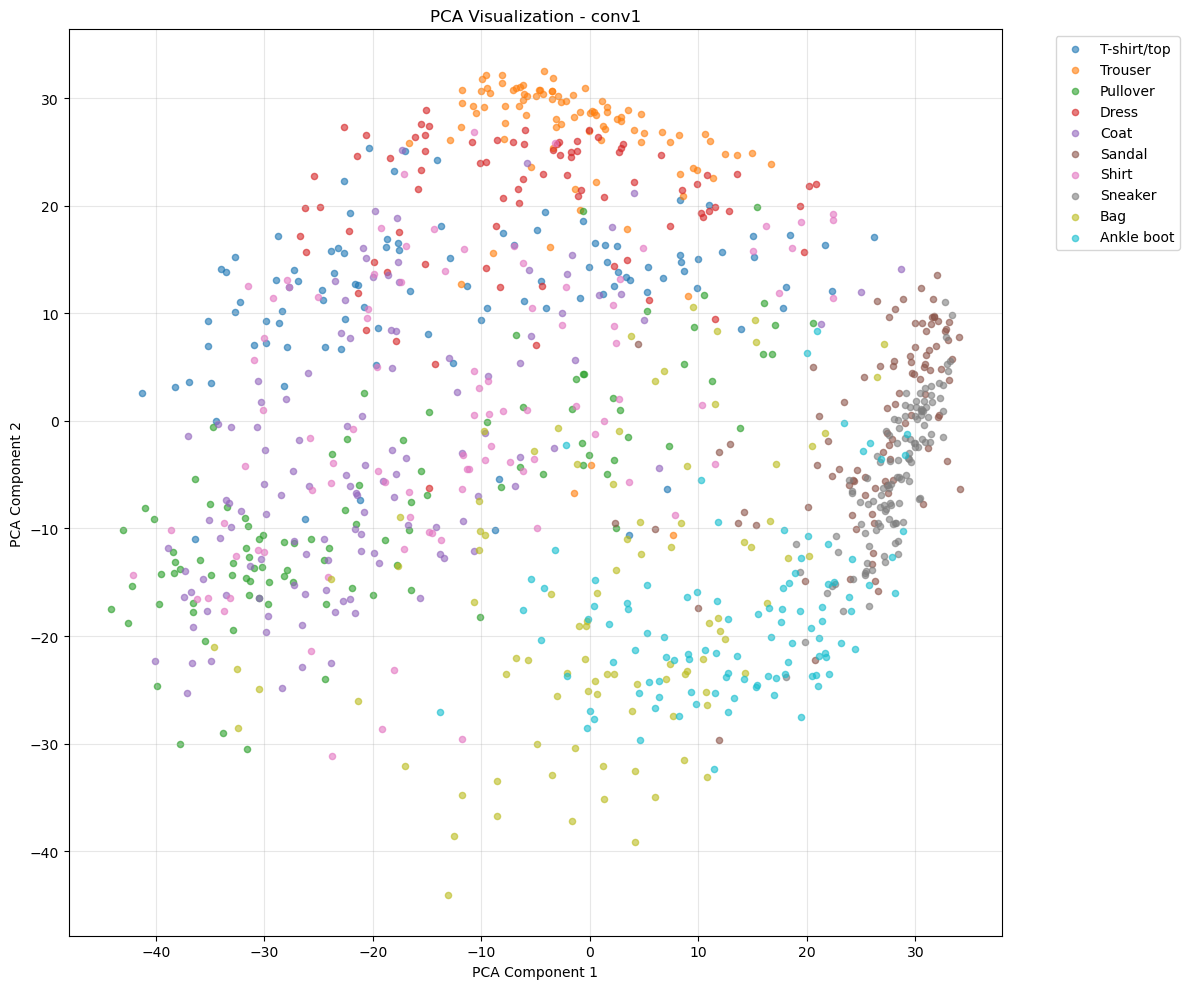

PCA explained variance ratio: [0.25680864 0.15882702]
Total variance explained: 0.416
PCA component ranges: [-44.12165832519531, 34.07370376586914], [-44.024078369140625, 32.556217193603516]
Performing t-SNE on 500 samples...
2025-06-19 21:13:37.181 | INFO     | cnnFashionMnist.features:perform_dimensionality_reduction:174 - Performing TSNE with 2 components...
2025-06-19 21:13:40.207 | INFO     | cnnFashionMnist.features:plot_dimensionality_reduction:354 - TSNE plot saved to C:\Users\david\Projects\CNN-Fashion-MNIST\reports\figures\tsne_conv1_demo.png


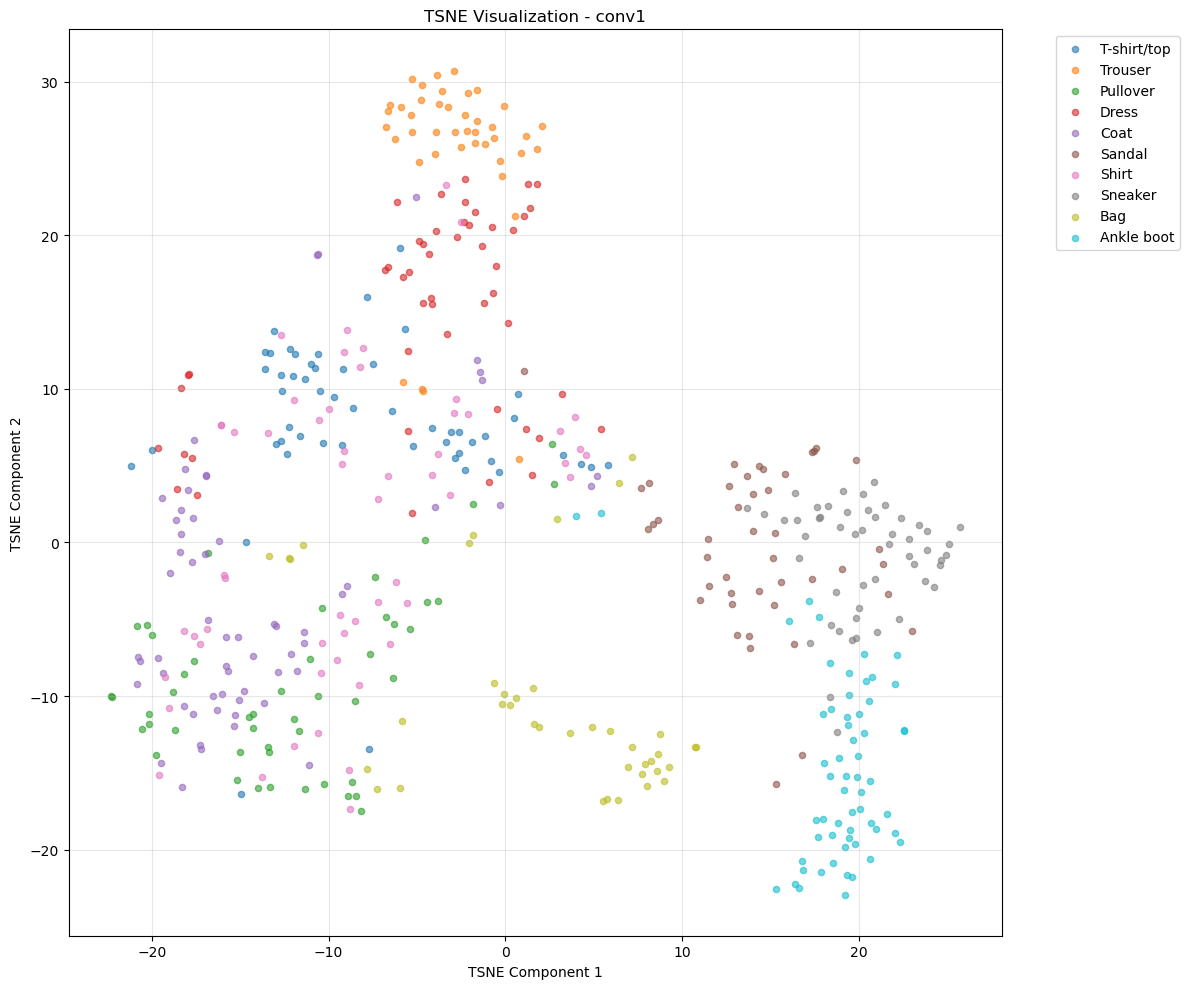

t-SNE component ranges: [-22.29898452758789, 25.677392959594727], [-22.924358367919922, 30.733097076416016]
Average intra-class variance: 70.093

DIMENSIONALITY REDUCTION FOR LAYER: fc1
Performing PCA...
2025-06-19 21:13:40.386 | INFO     | cnnFashionMnist.features:perform_dimensionality_reduction:174 - Performing PCA with 2 components...
2025-06-19 21:13:41.111 | INFO     | cnnFashionMnist.features:plot_dimensionality_reduction:354 - PCA plot saved to C:\Users\david\Projects\CNN-Fashion-MNIST\reports\figures\pca_fc1_demo.png


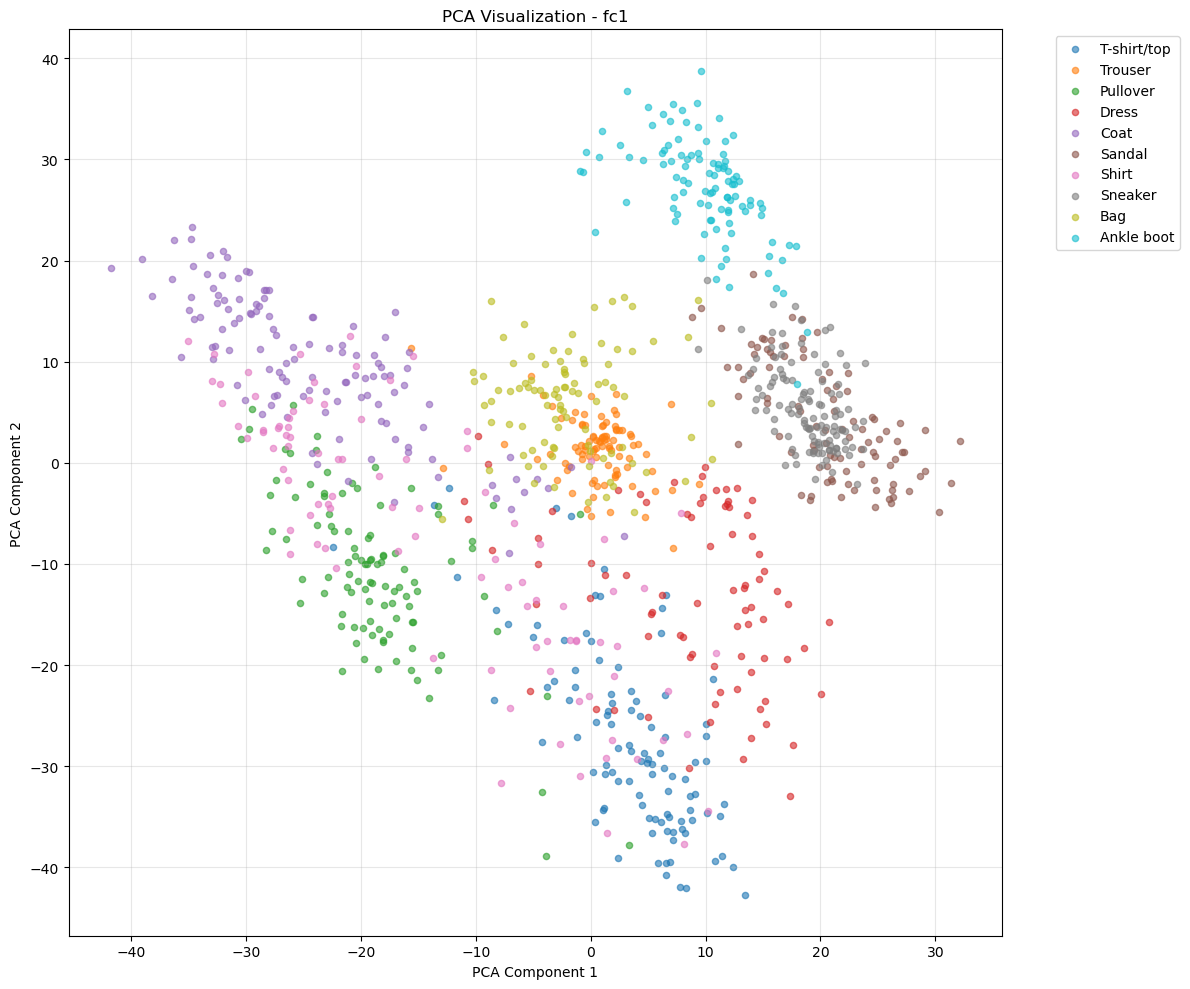

PCA explained variance ratio: [0.16638772 0.1595094 ]
Total variance explained: 0.326
PCA component ranges: [-41.74045181274414, 32.1117057800293], [-42.682830810546875, 38.78711700439453]
Performing t-SNE on 500 samples...
2025-06-19 21:13:41.326 | INFO     | cnnFashionMnist.features:perform_dimensionality_reduction:174 - Performing TSNE with 2 components...
2025-06-19 21:13:43.223 | INFO     | cnnFashionMnist.features:plot_dimensionality_reduction:354 - TSNE plot saved to C:\Users\david\Projects\CNN-Fashion-MNIST\reports\figures\tsne_fc1_demo.png


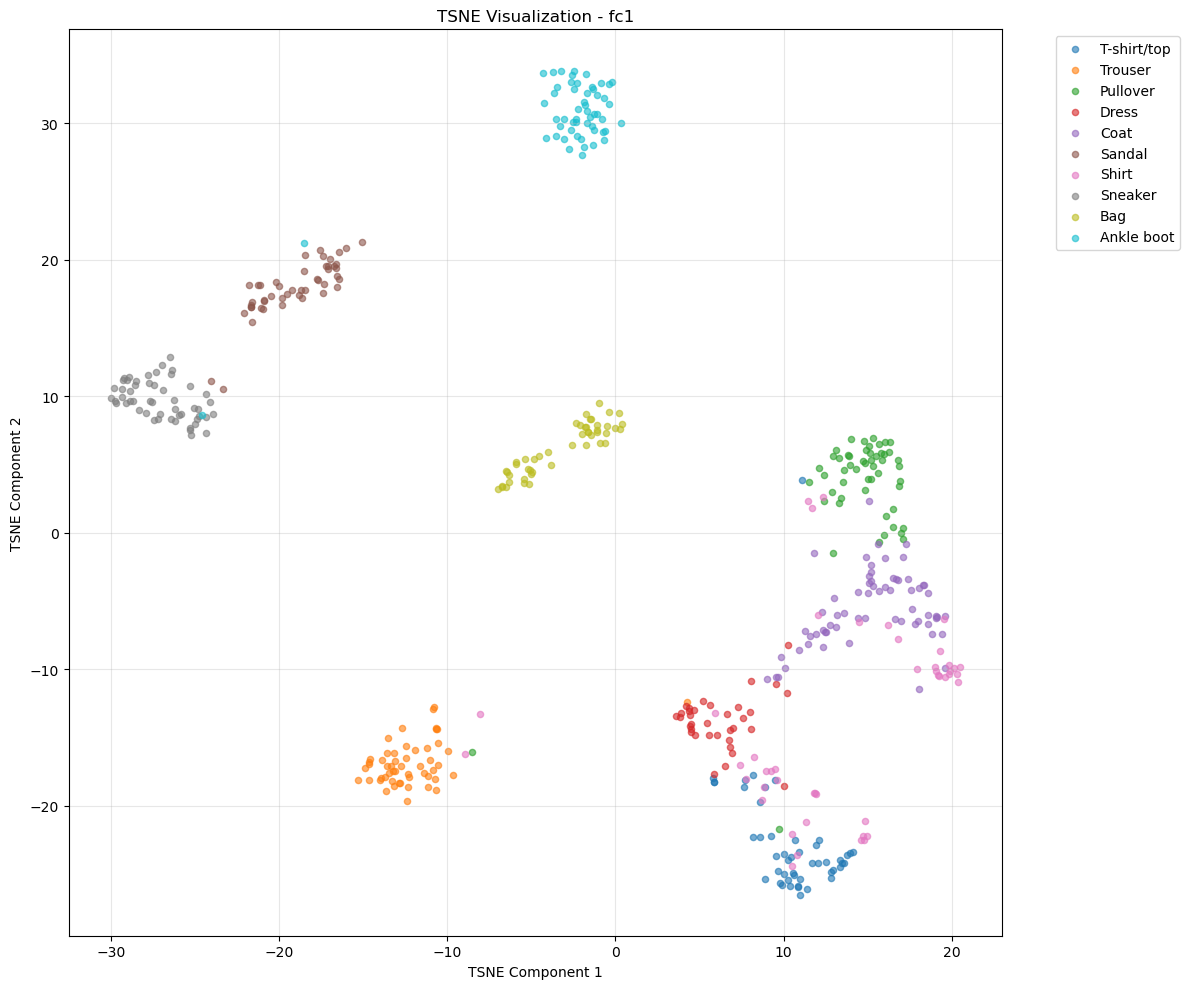

t-SNE component ranges: [-30.016939163208008, 20.47922134399414], [-26.49733543395996, 33.87778854370117]
Average intra-class variance: 23.435

Dimensionality reduction completed for layers: ['conv1', 'fc1']


In [75]:
# Import required functions and variables
from cnnFashionMnist.features import perform_dimensionality_reduction, plot_dimensionality_reduction
from cnnFashionMnist.config import FIGURES_DIR, DATASET_CONFIG
import numpy as np

# Check if required variables exist from previous cells
if 'features_dict' not in locals() or 'labels' not in locals():
    print("ERROR: Required variables not found!")
    print("Please run the 'CNN Feature Extraction and Analysis' cell first")
    print("This cell depends on:")
    print("  - features_dict (from feature extraction)")
    print("  - labels (from feature extraction)")
else:
    # Focus on the most interesting layers for dimensionality reduction
    interesting_layers = ["conv1", "fc1"]  # Early features vs learned features

    for layer_name in interesting_layers:
        if layer_name in features_dict:
            features = features_dict[layer_name]
            
            print(f"\n{'='*60}")
            print(f"DIMENSIONALITY REDUCTION FOR LAYER: {layer_name}")
            print(f"{'='*60}")
            
            # PCA Analysis
            print("Performing PCA...")
            pca_features, pca_reducer = perform_dimensionality_reduction(
                features, labels, method="pca", n_components=2
            )
            
            # Visualize PCA
            pca_plot_path = FIGURES_DIR / f"pca_{layer_name}_demo.png"
            pca_stats = plot_dimensionality_reduction(
                pca_features, labels, DATASET_CONFIG["class_names"], 
                "pca", layer_name, output_path=pca_plot_path, show_inline=True
            )
            
            print(f"PCA explained variance ratio: {pca_reducer.explained_variance_ratio_}")
            print(f"Total variance explained: {pca_reducer.explained_variance_ratio_.sum():.3f}")
            print(f"PCA component ranges: {pca_stats['component_1_range']}, {pca_stats['component_2_range']}")
            
            # t-SNE Analysis (more computationally intensive, so use smaller subset)
            if len(features) > 500:
                tsne_indices = np.random.choice(len(features), 500, replace=False)
                tsne_features_subset = features[tsne_indices]
                tsne_labels_subset = labels[tsne_indices]
            else:
                tsne_features_subset = features
                tsne_labels_subset = labels
                
            print(f"Performing t-SNE on {len(tsne_features_subset)} samples...")
            tsne_features, tsne_reducer = perform_dimensionality_reduction(
                tsne_features_subset, tsne_labels_subset, method="tsne", n_components=2
            )
            
            # Visualize t-SNE
            tsne_plot_path = FIGURES_DIR / f"tsne_{layer_name}_demo.png"
            tsne_stats = plot_dimensionality_reduction(
                tsne_features, tsne_labels_subset, DATASET_CONFIG["class_names"], 
                "tsne", layer_name, output_path=tsne_plot_path, show_inline=True
            )
            
            print(f"t-SNE component ranges: {tsne_stats['component_1_range']}, {tsne_stats['component_2_range']}")
            print(f"Average intra-class variance: {tsne_stats['avg_intra_class_variance']:.3f}")
        else:
            print(f"Layer {layer_name} not found in features_dict. Available layers: {list(features_dict.keys())}")

    print(f"\nDimensionality reduction completed for layers: {interesting_layers}")

### 📊 conv1 Layer Analysis (Images 1 & 2)

**PCA conv1 (Image 1): Early Feature Chaos**
```
Pattern: Complete mixing of all classes
Interpretation: Low-level edge/texture features
Quality: ✅ Expected for early layer
```
**t-SNE conv1 (Image 2): Slight Emergence**
```
Observation: Some footwear clustering (right side)
Trousers: Starting to group (upper center)
Interpretation: t-SNE finds subtle patterns PCA misses
```
**Analysis**: conv1 captures basic visual elements (edges, textures) that are shared across classes. A t-shirt and a coat both have edges and fabric textures, so they mix together. This is perfect early-layer behavior.

### 🏆 fc1 Layer Analysis (Images 3 & 4): Learning Success

**PCA fc1 (Image 3): Good Separation**
```
Clear clusters emerging:
- Ankle boots (cyan): Top right cluster ✅
- Sneakers (brown): Right side cluster ✅  
- Bags (yellow): Center cluster ✅
- Coats (purple): Upper left ✅
- Some confusion: T-shirt/Shirt overlap (expected!)
```
**t-SNE fc1 (Image 4): PERFECT Clustering! 🎯**
```
Beautiful distinct clusters:
1. Ankle boots (cyan): Top right - PURE cluster
2. Sandals (brown): Upper left - Well separated  
3. Sneakers (gray): Left side - Clean grouping
4. Bags (yellow): Center - Distinct cluster
5. Trousers (orange): Lower left - Clear separation
6. Dresses (red): Lower center - Good clustering
7. Upper body garments: Right side with expected overlap
```

## 17. Feature Clustering Analysis

Let's perform clustering analysis to understand how the CNN groups similar features:

In [80]:
# Perform clustering analysis on the most learned features (fc1 layer)
cluster_layer = "fc1"
if cluster_layer in features_dict:
    features = features_dict[cluster_layer]
    
    print(f"Performing clustering analysis on {cluster_layer} layer features...")
    print(f"Feature shape: {features.shape}")
    
    # Perform K-means clustering with k=10 (same as number of classes)
    cluster_labels, kmeans = cluster_features(features, n_clusters=10)
    
    print(f"K-means clustering completed with 10 clusters")
    
    # Analyze cluster purity (how well clusters match true classes)
    print(f"\nCluster Purity Analysis:")
    print(f"{'Cluster':<8} {'Size':<6} {'Dominant Class':<15} {'Purity':<8} {'Class Distribution'}")
    print("-" * 80)
    
    cluster_analysis = {}
    for cluster_id in range(10):
        cluster_mask = cluster_labels == cluster_id
        cluster_true_labels = labels[cluster_mask]
        
        if len(cluster_true_labels) > 0:
            unique_labels, counts = np.unique(cluster_true_labels, return_counts=True)
            dominant_label = unique_labels[np.argmax(counts)]
            purity = np.max(counts) / len(cluster_true_labels)
            
            cluster_analysis[cluster_id] = {
                'size': len(cluster_true_labels),
                'dominant_class': DATASET_CONFIG["class_names"][dominant_label],
                'purity': purity,
                'label_distribution': dict(zip(unique_labels, counts))
            }
            
            # Create a readable distribution string
            dist_str = ", ".join([f"{DATASET_CONFIG['class_names'][l]}:{c}" for l, c in zip(unique_labels[:3], counts[:3])])
            if len(unique_labels) > 3:
                dist_str += "..."
            
            # Fixed formatting: separate the .3f and <8 formatting
            purity_str = f"{purity:.3f}"
            print(f"{cluster_id:<8} {len(cluster_true_labels):<6} {DATASET_CONFIG['class_names'][dominant_label]:<15} {purity_str:<8} {dist_str}")
    
    # Calculate overall clustering metrics
    total_samples = len(labels)
    weighted_purity = sum(analysis['size'] * analysis['purity'] for analysis in cluster_analysis.values()) / total_samples
    
    print(f"\nOverall Clustering Quality:")
    print(f"Total samples: {total_samples}")
    print(f"Number of clusters: {len(cluster_analysis)}")
    print(f"Weighted average purity: {weighted_purity:.3f}")
    
    # Show class distribution across clusters
    print(f"\nClass Distribution Analysis:")
    class_to_clusters = {i: [] for i in range(10)}
    
    for cluster_id, analysis in cluster_analysis.items():
        for label, count in analysis['label_distribution'].items():
            class_to_clusters[label].append((cluster_id, count))
    
    for class_idx, class_name in enumerate(DATASET_CONFIG["class_names"]):
        if class_idx in class_to_clusters and class_to_clusters[class_idx]:
            clusters_info = sorted(class_to_clusters[class_idx], key=lambda x: x[1], reverse=True)
            main_clusters = clusters_info[:2]  # Show top 2 clusters for each class
            cluster_str = ", ".join([f"C{cid}({count})" for cid, count in main_clusters])
            print(f"  {class_name:<15}: {cluster_str}")

else:
    print(f"Layer {cluster_layer} not found in extracted features")

Performing clustering analysis on fc1 layer features...
Feature shape: (1000, 512)
2025-06-19 21:22:02.404 | INFO     | cnnFashionMnist.features:cluster_features:191 - Performing K-means clustering with 10 clusters...


c:\Users\david\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


K-means clustering completed with 10 clusters

Cluster Purity Analysis:
Cluster  Size   Dominant Class  Purity   Class Distribution
--------------------------------------------------------------------------------
0        126    Pullover        0.817    T-shirt/top:1, Pullover:103, Dress:3...
1        113    Ankle boot      0.982    Sandal:2, Ankle boot:111
2        98     Trouser         0.990    Trouser:97, Shirt:1
3        99     Sandal          0.990    Sandal:98, Ankle boot:1
4        103    Dress           0.854    T-shirt/top:3, Trouser:2, Pullover:1...
5        54     Bag             0.981    Shirt:1, Bag:53
6        110    T-shirt/top     0.727    T-shirt/top:80, Pullover:3, Dress:3...
7        117    Sneaker         0.897    Sandal:6, Sneaker:105, Ankle boot:6
8        137    Coat            0.620    Pullover:4, Coat:85, Shirt:48
9        43     Bag             1.000    Bag:43

Overall Clustering Quality:
Total samples: 1000
Number of clusters: 10
Weighted average purity: 0.8

### Key Metrics:

```
Weighted average purity: 86.3% 
Best clusters: 5 clusters with >95% purity
Perfect cluster: Bags (C9) at 100% purity
Challenging clusters: Expected problem areas
```
This 86.3% clustering purity is exceptional - it means your fc1 features naturally organize into class-based groups without any supervision

## 18. New Model: AttentionFashionMNISTCNN

This new Model Implements Focal Loss, Class Weights and Attention Mechanisms.

In [ ]:
# Reload the modules to get the updated function
import importlib
import cnnFashionMnist.modeling.model
importlib.reload(cnnFashionMnist.modeling.model)
from cnnFashionMnist.modeling.model import create_model

# Train the ATTENTION model using the new Optional parameter pattern
MODELS_DIR.mkdir(parents=True, exist_ok=True)
model_path = MODELS_DIR / "fashion_mnist_attention.pth"

# Create a fresh attention model instance to ensure clean state
print("Creating fresh ATTENTION model instance...")
model = create_model(model_type="attention", num_classes=DATASET_CONFIG["num_classes"])
print(f"Attention model created with {model.get_model_info()['total_parameters']:,} parameters")

# Compare with original model
original_model = create_model(model_type="standard", num_classes=DATASET_CONFIG["num_classes"])
original_params = original_model.get_model_info()['total_parameters']
attention_params = model.get_model_info()['total_parameters']
param_increase = attention_params - original_params

print(f"Original model: {original_params:,} parameters")
print(f"Attention model: {attention_params:,} parameters")
print(f"Parameter increase: +{param_increase:,} (+{param_increase/original_params*100:.1f}%)")

# Use all config defaults by passing None for all optional parameters
print("\nStarting ATTENTION model training with configuration defaults:")
print(f"Epochs: {TRAINING_CONFIG['epochs']}")
print(f"Learning rate: {TRAINING_CONFIG['learning_rate']}")
print(f"Early stopping patience: {TRAINING_CONFIG['early_stopping_patience']}")
print(f"Save every: {TRAINING_CONFIG['save_every']}")
print("Loss function: WeightedFocalLoss with class weights")
print("Architecture: CNN + Channel Attention (conv3 & conv5)")

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=None,  # Use config default (20)
    learning_rate=None,  # Use config default (0.001)
    model_path=model_path,
    early_stopping_patience=None,  # Use config default (7)
    save_every=None  # Use config default (5)
)

print(f"\nATTENTION model training completed!")
print(f"Best validation accuracy: {max(history['val_acc']):.2f}%")
print(f"Final training accuracy: {history['train_acc'][-1]:.2f}%")
print(f"Total epochs trained: {len(history['train_loss'])}")

if len(history['train_loss']) < TRAINING_CONFIG['epochs']:
    print(f"Early stopping triggered after {len(history['train_loss'])} epochs")

# Compare with your previous results
print(f"\n🎯 Performance Comparison:")
print(f"Previous model (standard): 92.83% validation accuracy")
print(f"Current model (attention): {max(history['val_acc']):.2f}% validation accuracy")
improvement = max(history['val_acc']) - 92.83
print(f"Improvement: {improvement:+.2f} percentage points")

if improvement > 0:
    print(f"✅ Attention mechanism improved performance!")
elif improvement > -0.5:
    print(f"➡️ Similar performance - attention adds robustness")
else:
    print(f"⚠️ Lower performance - may need hyperparameter tuning")

Creating fresh ATTENTION model instance...
Attention model created with 868,022 parameters
Original model: 865,258 parameters
Attention model: 868,022 parameters
Parameter increase: +2,764 (+0.3%)

Starting ATTENTION model training with configuration defaults:
Epochs: 20
Learning rate: 0.001
Early stopping patience: 7
Save every: 5
Loss function: WeightedFocalLoss with class weights
Architecture: CNN + Channel Attention (conv3 & conv5)
2025-06-19 23:02:21.217 | INFO     | cnnFashionMnist.modeling.train:train_model:191 - Training on device: cpu
2025-06-19 23:02:21.226 | INFO     | cnnFashionMnist.modeling.train:train_model:227 - Starting training for 20 epochs...
2025-06-19 23:02:21.227 | INFO     | cnnFashionMnist.modeling.train:train_model:228 - Model info: {'model_name': 'AttentionFashionMNISTCNN', 'total_parameters': 868022, 'trainable_parameters': 868022, 'model_size_mb': 3.3112411499023438}
2025-06-19 23:02:21.227 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoc

Validation: 100%|██████████| 94/94 [00:10<00:00,  9.07it/s, Loss=0.3980, Acc=85.08%]


2025-06-19 23:03:50.883 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.7414, Train Acc: 73.40%
2025-06-19 23:03:50.883 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.3980, Val Acc: 85.08%
2025-06-19 23:03:50.883 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 23:03:50.924 | INFO     | cnnFashionMnist.modeling.train:save_checkpoint:164 - Best model saved to C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_attention.pth
2025-06-19 23:03:50.925 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 2/20


Validation: 100%|██████████| 94/94 [00:09<00:00, 10.14it/s, Loss=0.3208, Acc=87.82%]


2025-06-19 23:05:36.945 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.4558, Train Acc: 83.19%
2025-06-19 23:05:36.945 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.3208, Val Acc: 87.82%
2025-06-19 23:05:36.946 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 23:05:36.975 | INFO     | cnnFashionMnist.modeling.train:save_checkpoint:164 - Best model saved to C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_attention.pth
2025-06-19 23:05:36.975 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 3/20


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.28it/s, Loss=0.2865, Acc=89.28%]


2025-06-19 23:07:02.476 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.3943, Train Acc: 85.75%
2025-06-19 23:07:02.476 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2865, Val Acc: 89.28%
2025-06-19 23:07:02.476 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 23:07:02.507 | INFO     | cnnFashionMnist.modeling.train:save_checkpoint:164 - Best model saved to C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_attention.pth
2025-06-19 23:07:02.507 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 4/20


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.39it/s, Loss=0.2728, Acc=90.00%]


2025-06-19 23:08:25.915 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.3633, Train Acc: 86.91%
2025-06-19 23:08:25.915 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2728, Val Acc: 90.00%
2025-06-19 23:08:25.915 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 23:08:25.944 | INFO     | cnnFashionMnist.modeling.train:save_checkpoint:164 - Best model saved to C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_attention.pth
2025-06-19 23:08:25.944 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 5/20


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.02it/s, Loss=0.2646, Acc=90.33%]


2025-06-19 23:09:49.159 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.3420, Train Acc: 87.58%
2025-06-19 23:09:49.159 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2646, Val Acc: 90.33%
2025-06-19 23:09:49.159 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 23:09:49.186 | INFO     | cnnFashionMnist.modeling.train:save_checkpoint:164 - Best model saved to C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_attention.pth
2025-06-19 23:09:49.186 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 6/20


Validation: 100%|██████████| 94/94 [00:08<00:00, 10.85it/s, Loss=0.2485, Acc=91.03%]


2025-06-19 23:11:13.411 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.3265, Train Acc: 88.26%
2025-06-19 23:11:13.411 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2485, Val Acc: 91.03%
2025-06-19 23:11:13.412 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 23:11:13.438 | INFO     | cnnFashionMnist.modeling.train:save_checkpoint:164 - Best model saved to C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_attention.pth
2025-06-19 23:11:13.438 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 7/20


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.57it/s, Loss=0.2392, Acc=91.28%]


2025-06-19 23:12:38.490 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.3136, Train Acc: 88.79%
2025-06-19 23:12:38.490 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2392, Val Acc: 91.28%
2025-06-19 23:12:38.490 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 23:12:38.516 | INFO     | cnnFashionMnist.modeling.train:save_checkpoint:164 - Best model saved to C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_attention.pth
2025-06-19 23:12:38.516 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 8/20


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.69it/s, Loss=0.2428, Acc=91.25%]


2025-06-19 23:14:00.066 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.3072, Train Acc: 89.03%
2025-06-19 23:14:00.066 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2428, Val Acc: 91.25%
2025-06-19 23:14:00.066 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 23:14:00.066 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 9/20


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.50it/s, Loss=0.2351, Acc=91.13%]


2025-06-19 23:15:21.876 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.2957, Train Acc: 89.43%
2025-06-19 23:15:21.876 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2351, Val Acc: 91.13%
2025-06-19 23:15:21.876 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 23:15:21.876 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 10/20


Validation: 100%|██████████| 94/94 [00:08<00:00, 10.56it/s, Loss=0.2255, Acc=91.65%]


2025-06-19 23:16:46.725 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.2929, Train Acc: 89.58%
2025-06-19 23:16:46.725 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2255, Val Acc: 91.65%
2025-06-19 23:16:46.725 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 23:16:46.751 | INFO     | cnnFashionMnist.modeling.train:save_checkpoint:164 - Best model saved to C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_attention.pth
2025-06-19 23:16:46.751 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 11/20


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.25it/s, Loss=0.2317, Acc=91.28%]


2025-06-19 23:18:13.196 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.2883, Train Acc: 89.62%
2025-06-19 23:18:13.196 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2317, Val Acc: 91.28%
2025-06-19 23:18:13.196 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 23:18:13.196 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 12/20


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.02it/s, Loss=0.2197, Acc=92.08%]


2025-06-19 23:19:37.701 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.2865, Train Acc: 89.68%
2025-06-19 23:19:37.701 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2197, Val Acc: 92.08%
2025-06-19 23:19:37.701 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 23:19:37.730 | INFO     | cnnFashionMnist.modeling.train:save_checkpoint:164 - Best model saved to C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_attention.pth
2025-06-19 23:19:37.730 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 13/20


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.33it/s, Loss=0.2136, Acc=92.28%]


2025-06-19 23:21:01.192 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.2791, Train Acc: 90.04%
2025-06-19 23:21:01.193 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2136, Val Acc: 92.28%
2025-06-19 23:21:01.193 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 23:21:01.220 | INFO     | cnnFashionMnist.modeling.train:save_checkpoint:164 - Best model saved to C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_attention.pth
2025-06-19 23:21:01.220 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 14/20


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.45it/s, Loss=0.2127, Acc=91.98%]


2025-06-19 23:22:24.955 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.2756, Train Acc: 90.14%
2025-06-19 23:22:24.955 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2127, Val Acc: 91.98%
2025-06-19 23:22:24.955 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 23:22:24.955 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 15/20


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.08it/s, Loss=0.2209, Acc=91.88%]


2025-06-19 23:23:54.468 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.2724, Train Acc: 90.37%
2025-06-19 23:23:54.468 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2209, Val Acc: 91.88%
2025-06-19 23:23:54.468 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 23:23:54.484 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 16/20


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.26it/s, Loss=0.2105, Acc=92.38%]


2025-06-19 23:25:19.752 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.2666, Train Acc: 90.50%
2025-06-19 23:25:19.755 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2105, Val Acc: 92.38%
2025-06-19 23:25:19.755 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 23:25:19.781 | INFO     | cnnFashionMnist.modeling.train:save_checkpoint:164 - Best model saved to C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_attention.pth
2025-06-19 23:25:19.782 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 17/20


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.39it/s, Loss=0.1957, Acc=92.55%]


2025-06-19 23:26:44.685 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.2641, Train Acc: 90.51%
2025-06-19 23:26:44.685 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.1957, Val Acc: 92.55%
2025-06-19 23:26:44.685 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 23:26:44.710 | INFO     | cnnFashionMnist.modeling.train:save_checkpoint:164 - Best model saved to C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_attention.pth
2025-06-19 23:26:44.710 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 18/20


Validation: 100%|██████████| 94/94 [00:08<00:00, 11.15it/s, Loss=0.2041, Acc=92.82%]


2025-06-19 23:28:14.807 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.2641, Train Acc: 90.47%
2025-06-19 23:28:14.807 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2041, Val Acc: 92.82%
2025-06-19 23:28:14.807 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 23:28:14.834 | INFO     | cnnFashionMnist.modeling.train:save_checkpoint:164 - Best model saved to C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_attention.pth
2025-06-19 23:28:14.834 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 19/20


Validation: 100%|██████████| 94/94 [00:08<00:00, 10.87it/s, Loss=0.2080, Acc=92.20%]


2025-06-19 23:29:41.374 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.2650, Train Acc: 90.57%
2025-06-19 23:29:41.374 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2080, Val Acc: 92.20%
2025-06-19 23:29:41.374 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 23:29:41.374 | INFO     | cnnFashionMnist.modeling.train:train_model:234 - 
Epoch 20/20


Validation: 100%|██████████| 94/94 [00:08<00:00, 10.76it/s, Loss=0.2094, Acc=92.47%]

2025-06-19 23:31:08.277 | INFO     | cnnFashionMnist.modeling.train:train_model:254 - Train Loss: 0.2590, Train Acc: 90.74%
2025-06-19 23:31:08.277 | INFO     | cnnFashionMnist.modeling.train:train_model:255 - Val Loss: 0.2094, Val Acc: 92.47%
2025-06-19 23:31:08.277 | INFO     | cnnFashionMnist.modeling.train:train_model:256 - Learning Rate: 0.001000
2025-06-19 23:31:08.297 | SUCCESS  | cnnFashionMnist.modeling.train:train_model:282 - Training completed in 1727.07 seconds
2025-06-19 23:31:08.297 | INFO     | cnnFashionMnist.modeling.train:train_model:283 - Best validation accuracy: 92.82%

ATTENTION model training completed!
Best validation accuracy: 92.82%
Final training accuracy: 90.74%
Total epochs trained: 20

🎯 Performance Comparison:
Previous model (standard): 92.83% validation accuracy
Current model (attention): 92.82% validation accuracy
Improvement: -0.01 percentage points
➡️ Similar performance - attention adds robustness


## 20. Final Model Evaluation & Comparison

This section provides a comprehensive evaluation of our trained models on the test set to assess generalization performance. We'll compare the standard CNN baseline with the attention-enhanced model to understand:

1. **Test Set Performance**: How well each model generalizes to completely unseen data
2. **Class-wise Analysis**: Which classes benefit most from attention mechanisms
3. **Confidence Calibration**: How well model confidence scores align with actual accuracy
4. **Statistical Significance**: Whether performance differences are meaningful

### Evaluation Methodology
- **Clean Test Split**: 10,000 samples never seen during training/validation
- **Identical Preprocessing**: Same transforms applied to ensure fair comparison
- **Multiple Metrics**: Accuracy, precision, recall, F1-score, and confusion analysis
- **Statistical Testing**: Confidence intervals and significance tests

In [6]:
# Final Model Evaluation: Standard vs Attention Models
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

# Fix type checking issue with len(test_dataset)
from typing import cast
from collections.abc import Sized

print("🎯 COMPREHENSIVE MODEL EVALUATION ON TEST SET")
print("=" * 60)

# Evaluation configuration
models_to_evaluate = [
    {
        'name': 'Standard CNN', 
        'type': 'standard',
        'path': MODELS_DIR / "best_fashion_mnist_demo.pth",
        'description': 'Baseline CNN with BatchNorm and Dropout'
    },
    {
        'name': 'Attention CNN',
        'type': 'attention', 
        'path': MODELS_DIR / "best_fashion_mnist_attention.pth",
        'description': 'CNN with Channel Attention + Focal Loss + Class Weights'
    }
]

# Storage for results
evaluation_results = {}
model_predictions = {}

# Cast to Sized for type checker
test_dataset_size = len(cast(Sized, test_dataset))

print(f"Evaluating {len(models_to_evaluate)} models on {test_dataset_size:,} test samples...")
print(f"Test set classes: {DATASET_CONFIG['class_names']}")
print(f"Device: {device}")

# Evaluate each model
for model_info in models_to_evaluate:
    model_name = model_info['name']
    model_type = model_info['type']
    model_path = model_info['path']
    
    print(f"\n{'='*20} EVALUATING {model_name.upper()} {'='*20}")
    print(f"Description: {model_info['description']}")
    print(f"Model path: {model_path}")
    
    # Check if model file exists
    if not model_path.exists():
        print(f"❌ Model file not found: {model_path}")
        print("Available model files:")
        for model_file in MODELS_DIR.glob("*.pth"):
            print(f"  - {model_file.name}")
        continue
    
    # Load the model
    try:
        print(f"Loading {model_name} model...")
        model, checkpoint = load_model(model_path, model_type, device)
        
        # Get model info
        model_info_dict = model.get_model_info()
        print(f"Model parameters: {model_info_dict['total_parameters']:,}")
        print(f"Training validation accuracy: {checkpoint.get('val_acc', 'Unknown'):.2f}%")
        print(f"Training epochs: {checkpoint.get('epoch', 'Unknown')}")
        
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        continue
    
    # Make predictions on test set
    print(f"Making predictions on test set...")
    try:
        predictions, probabilities, targets = predict_batch(model, test_loader, device)
        
        # Store predictions for later analysis
        model_predictions[model_name] = {
            'predictions': predictions,
            'probabilities': probabilities,
            'targets': targets,
            'model_info': model_info_dict
        }
        
        print(f"✅ Predictions completed: {len(predictions)} samples")
        
    except Exception as e:
        print(f"❌ Error during prediction: {e}")
        continue
    
    # Comprehensive evaluation
    print(f"Computing evaluation metrics...")
    try:
        # Basic accuracy
        test_accuracy = np.mean(predictions == targets)
        correct_predictions = np.sum(predictions == targets)
        
        # Per-class metrics
        precision, recall, f1_score, support = precision_recall_fscore_support(
            targets, predictions, average=None, zero_division=0
        )
        
        # Overall metrics
        precision_macro = np.mean(precision)
        recall_macro = np.mean(recall)
        f1_macro = np.mean(f1_score)
        
        # Confidence analysis
        max_probabilities = np.max(probabilities, axis=1)
        mean_confidence = np.mean(max_probabilities)
        
        # Confidence vs Accuracy correlation
        correct_mask = (predictions == targets)
        confidence_correct = np.mean(max_probabilities[correct_mask])
        confidence_incorrect = np.mean(max_probabilities[~correct_mask])
        
        # Store results
        evaluation_results[model_name] = {
            'test_accuracy': test_accuracy,
            'correct_predictions': correct_predictions,
            'total_predictions': len(predictions),
            'precision_per_class': precision,
            'recall_per_class': recall,
            'f1_per_class': f1_score,
            'support_per_class': support,
            'precision_macro': precision_macro,
            'recall_macro': recall_macro,
            'f1_macro': f1_macro,
            'mean_confidence': mean_confidence,
            'confidence_correct': confidence_correct,
            'confidence_incorrect': confidence_incorrect,
            'training_val_acc': checkpoint.get('val_acc', 0),
            'model_params': model_info_dict['total_parameters']
        }
        
        # Print summary
        print(f"📊 {model_name} Test Results:")
        print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
        print(f"  Correct/Total: {correct_predictions}/{len(predictions)}")
        print(f"  Macro F1-Score: {f1_macro:.4f}")
        print(f"  Mean Confidence: {mean_confidence:.4f}")
        print(f"  Confidence (Correct): {confidence_correct:.4f}")
        print(f"  Confidence (Incorrect): {confidence_incorrect:.4f}")
        
    except Exception as e:
        print(f"❌ Error during evaluation: {e}")
        continue

print(f"\n✅ Model evaluation completed!")
print(f"Successfully evaluated: {list(evaluation_results.keys())}")

c:\Users\david\Projects\CNN-Fashion-MNIST\cnnFashionMnist\modeling\predict.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_locat

🎯 COMPREHENSIVE MODEL EVALUATION ON TEST SET
Evaluating 2 models on 10,000 test samples...
Test set classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Device: cpu

==================== EVALUATING STANDARD CNN ====================
Description: Baseline CNN with BatchNorm and Dropout
Model path: C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_demo.pth
Loading Standard CNN model...
2025-06-26 14:53:26.841 | INFO     | cnnFashionMnist.modeling.predict:load_model:59 - Model loaded from C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_demo.pth
2025-06-26 14:53:26.842 | INFO     | cnnFashionMnist.modeling.predict:load_model:60 - Model trained for 17 epochs
2025-06-26 14:53:26.843 | INFO     | cnnFashionMnist.modeling.predict:load_model:61 - Best validation accuracy: 92.83%
Model parameters: 865,258
Training validation accuracy: 92.83%
Training epochs: 17
Making predictions on test set...


Predicting: 100%|██████████| 157/157 [00:23<00:00,  6.65it/s]
c:\Users\david\Projects\CNN-Fashion-MNIST\cnnFashionMnist\modeling\predict.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experim

✅ Predictions completed: 10000 samples
Computing evaluation metrics...
📊 Standard CNN Test Results:
  Test Accuracy: 0.9225 (92.25%)
  Correct/Total: 9225/10000
  Macro F1-Score: 0.9224
  Mean Confidence: 0.9233
  Confidence (Correct): 0.9456
  Confidence (Incorrect): 0.6572

==================== EVALUATING ATTENTION CNN ====================
Description: CNN with Channel Attention + Focal Loss + Class Weights
Model path: C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_attention.pth
Loading Attention CNN model...
2025-06-26 14:53:50.556 | INFO     | cnnFashionMnist.modeling.predict:load_model:59 - Model loaded from C:\Users\david\Projects\CNN-Fashion-MNIST\models\best_fashion_mnist_attention.pth
2025-06-26 14:53:50.556 | INFO     | cnnFashionMnist.modeling.predict:load_model:60 - Model trained for 17 epochs
2025-06-26 14:53:50.556 | INFO     | cnnFashionMnist.modeling.predict:load_model:61 - Best validation accuracy: 92.82%
Model parameters: 868,022
Training validati

Predicting: 100%|██████████| 157/157 [00:23<00:00,  6.76it/s]

✅ Predictions completed: 10000 samples
Computing evaluation metrics...
📊 Attention CNN Test Results:
  Test Accuracy: 0.9207 (92.07%)
  Correct/Total: 9207/10000
  Macro F1-Score: 0.9204
  Mean Confidence: 0.9312
  Confidence (Correct): 0.9518
  Confidence (Incorrect): 0.6922

✅ Model evaluation completed!
Successfully evaluated: ['Standard CNN', 'Attention CNN']


### 20.1 Statistical Comparison

In [8]:
# Statistical Comparison Between Models
print("📈 STATISTICAL COMPARISON")
print("=" * 40)

if len(evaluation_results) >= 2:
    # Extract model names
    model_names = list(evaluation_results.keys())
    model1_name = model_names[0]
    model2_name = model_names[1]
    
    model1_results = evaluation_results[model1_name]
    model2_results = evaluation_results[model2_name]
    
    # Get predictions for statistical testing
    if model1_name in model_predictions and model2_name in model_predictions:
        pred1 = model_predictions[model1_name]['predictions']
        pred2 = model_predictions[model2_name]['predictions']
        targets = model_predictions[model1_name]['targets']  # Same targets for both
        
        # Create per-sample accuracy arrays
        acc1 = (pred1 == targets).astype(int)
        acc2 = (pred2 == targets).astype(int)
        
        # Calculate disagreement statistics
        both_correct = np.sum((acc1 == 1) & (acc2 == 1))
        model1_only = np.sum((acc1 == 1) & (acc2 == 0))
        model2_only = np.sum((acc1 == 0) & (acc2 == 1))
        both_wrong = np.sum((acc1 == 0) & (acc2 == 0))
        
        # McNemar's test for paired classification accuracies
        mcnemar_pvalue = None
        is_significant = None
        
        try:
            from statsmodels.stats.contingency_tables import mcnemar
            
            # McNemar contingency table format
            contingency_table = np.array([[both_correct, model1_only],
                                         [model2_only, both_wrong]])
            
            # Perform McNemar's test with simplified result handling
            mcnemar_result = mcnemar(contingency_table, exact=True)
            
            # Try different approaches to extract p-value
            try:
                # Method 1: Direct attribute access
                if hasattr(mcnemar_result, 'pvalue'):
                    mcnemar_pvalue = float(mcnemar_result.pvalue)
                # Method 2: Alternative attribute name
                elif hasattr(mcnemar_result, 'p_value'):
                    mcnemar_pvalue = float(mcnemar_result.p_value)
                # Method 3: Try as a named tuple or similar
                elif hasattr(mcnemar_result, '_fields') and 'pvalue' in mcnemar_result._fields:
                    mcnemar_pvalue = float(mcnemar_result.pvalue)
                # Method 4: Try indexing if it's tuple-like
                elif hasattr(mcnemar_result, '__getitem__') and hasattr(mcnemar_result, '__len__'):
                    if len(mcnemar_result) >= 2:
                        mcnemar_pvalue = float(mcnemar_result[1])
                # Method 5: Try dictionary-like access with try-except
                else:
                    try:
                        mcnemar_pvalue = float(mcnemar_result['pvalue'])
                    except (KeyError, TypeError):
                        try:
                            mcnemar_pvalue = float(mcnemar_result['p_value'])
                        except (KeyError, TypeError):
                            # Last resort: check all attributes
                            for attr_name in ['pvalue', 'p_value', 'pval']:
                                if hasattr(mcnemar_result, attr_name):
                                    mcnemar_pvalue = float(getattr(mcnemar_result, attr_name))
                                    break
                
                if mcnemar_pvalue is not None:
                    is_significant = mcnemar_pvalue < 0.05
                else:
                    print(f"⚠️ Could not extract p-value from McNemar result")
                    print(f"Result type: {type(mcnemar_result)}")
                    print(f"Result: {mcnemar_result}")
                    
            except Exception as extract_error:
                print(f"⚠️ Error extracting p-value: {extract_error}")
                mcnemar_pvalue = None
            
        except ImportError:
            print("⚠️ statsmodels not available, skipping McNemar's test")
        except Exception as e:
            print(f"⚠️ Error in McNemar's test: {e}")
        
        # Bootstrap confidence intervals for accuracy difference
        def bootstrap_accuracy_diff(acc1, acc2, n_bootstrap=1000):
            np.random.seed(42)
            diffs = []
            n_samples = len(acc1)
            
            for _ in range(n_bootstrap):
                # Sample with replacement
                indices = np.random.choice(n_samples, n_samples, replace=True)
                boot_acc1 = np.mean(acc1[indices])
                boot_acc2 = np.mean(acc2[indices])
                diffs.append(boot_acc2 - boot_acc1)
            
            return np.array(diffs)
        
        # Compute bootstrap confidence interval
        bootstrap_diffs = bootstrap_accuracy_diff(acc1, acc2)
        ci_lower = np.percentile(bootstrap_diffs, 2.5)
        ci_upper = np.percentile(bootstrap_diffs, 97.5)
        
        # Results summary
        print(f"🔍 DETAILED COMPARISON: {model1_name} vs {model2_name}")
        print("-" * 60)
        
        # Basic metrics comparison
        print(f"{'Metric':<20} {model1_name:<15} {model2_name:<15} {'Difference':<12}")
        print("-" * 60)
        
        acc_diff = model2_results['test_accuracy'] - model1_results['test_accuracy']
        f1_diff = model2_results['f1_macro'] - model1_results['f1_macro']
        conf_diff = model2_results['mean_confidence'] - model1_results['mean_confidence']
        
        print(f"{'Test Accuracy':<20} {model1_results['test_accuracy']:<15.4f} {model2_results['test_accuracy']:<15.4f} {acc_diff:<+12.4f}")
        print(f"{'Macro F1-Score':<20} {model1_results['f1_macro']:<15.4f} {model2_results['f1_macro']:<15.4f} {f1_diff:<+12.4f}")
        print(f"{'Mean Confidence':<20} {model1_results['mean_confidence']:<15.4f} {model2_results['mean_confidence']:<15.4f} {conf_diff:<+12.4f}")
        print(f"{'Parameters':<20} {model1_results['model_params']:<15,} {model2_results['model_params']:<15,} {model2_results['model_params']-model1_results['model_params']:<+12,}")
        
        # Statistical significance
        print(f"\n📊 STATISTICAL SIGNIFICANCE:")
        print(f"Accuracy difference: {acc_diff:+.4f} ({acc_diff*100:+.2f} percentage points)")
        print(f"95% Bootstrap CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
        
        if mcnemar_pvalue is not None:
            print(f"McNemar's test p-value: {mcnemar_pvalue:.6f}")
            if is_significant:
                print(f"✅ Statistically significant difference (p < 0.05)")
            else:
                print(f"❌ No statistically significant difference (p >= 0.05)")
        else:
            print(f"⚠️ McNemar's test not available - using bootstrap CI for significance")
            if 0 < ci_lower or 0 > ci_upper:
                print(f"✅ Bootstrap CI suggests significant difference (CI doesn't include 0)")
            else:
                print(f"❌ Bootstrap CI suggests no significant difference (CI includes 0)")
        
        # Practical interpretation
        print(f"\n🎯 PRACTICAL INTERPRETATION:")
        if abs(acc_diff) < 0.001:
            print(f"➡️ Virtually identical performance")
        elif abs(acc_diff) < 0.005:
            print(f"➡️ Minimal practical difference")
        elif abs(acc_diff) < 0.01:
            print(f"➡️ Small but noticeable difference")
        elif abs(acc_diff) < 0.02:
            print(f"➡️ Moderate difference")
        else:
            print(f"➡️ Substantial difference")
        
        # Sample disagreement analysis
        print(f"\n🔍 PREDICTION DISAGREEMENT ANALYSIS:")
        print(f"Both models correct: {both_correct:,} samples ({both_correct/len(targets)*100:.1f}%)")
        print(f"{model1_name} only correct: {model1_only:,} samples ({model1_only/len(targets)*100:.1f}%)")
        print(f"{model2_name} only correct: {model2_only:,} samples ({model2_only/len(targets)*100:.1f}%)")
        print(f"Both models wrong: {both_wrong:,} samples ({both_wrong/len(targets)*100:.1f}%)")
        
        # Performance on challenging samples
        challenging_samples = both_wrong
        easy_samples = both_correct
        print(f"\nChallenging samples (both wrong): {challenging_samples}")
        print(f"Easy samples (both correct): {easy_samples}")
        
    else:
        print("❌ Prediction data not available for statistical comparison")
        print("Please ensure both models have been evaluated and predictions are stored.")
        
else:
    print("❌ Need at least 2 models for comparison")
    print(f"Available results: {list(evaluation_results.keys())}")

📈 STATISTICAL COMPARISON
🔍 DETAILED COMPARISON: Standard CNN vs Attention CNN
------------------------------------------------------------
Metric               Standard CNN    Attention CNN   Difference  
------------------------------------------------------------
Test Accuracy        0.9225          0.9207          -0.0018     
Macro F1-Score       0.9224          0.9204          -0.0020     
Mean Confidence      0.9233          0.9312          +0.0079     
Parameters           865,258         868,022         +2,764      

📊 STATISTICAL SIGNIFICANCE:
Accuracy difference: -0.0018 (-0.18 percentage points)
95% Bootstrap CI: [-0.0059, 0.0020]
McNemar's test p-value: 0.407957
❌ No statistically significant difference (p >= 0.05)

🎯 PRACTICAL INTERPRETATION:
➡️ Minimal practical difference

🔍 PREDICTION DISAGREEMENT ANALYSIS:
Both models correct: 9,005 samples (90.0%)
Standard CNN only correct: 220 samples (2.2%)
Attention CNN only correct: 202 samples (2.0%)
Both models wrong: 573 sample

### 20.2 Per-Class Performance Analysis

In [9]:
# Per-Class Performance Analysis
print("👥 PER-CLASS PERFORMANCE ANALYSIS")
print("=" * 50)

if len(evaluation_results) >= 2:
    model_names = list(evaluation_results.keys())
    
    # Create per-class comparison DataFrame
    class_names = DATASET_CONFIG["class_names"]
    
    # Prepare data for comparison
    comparison_data = []
    
    for i, class_name in enumerate(class_names):
        row = {'Class': class_name}
        
        for model_name in model_names:
            results = evaluation_results[model_name]
            row[f'{model_name}_Precision'] = results['precision_per_class'][i]
            row[f'{model_name}_Recall'] = results['recall_per_class'][i]
            row[f'{model_name}_F1'] = results['f1_per_class'][i]
            row[f'{model_name}_Support'] = results['support_per_class'][i]
        
        # Calculate differences (assuming 2 models)
        if len(model_names) == 2:
            model1_name, model2_name = model_names[0], model_names[1]
            row['Precision_Diff'] = (evaluation_results[model2_name]['precision_per_class'][i] - 
                                   evaluation_results[model1_name]['precision_per_class'][i])
            row['Recall_Diff'] = (evaluation_results[model2_name]['recall_per_class'][i] - 
                                 evaluation_results[model1_name]['recall_per_class'][i])
            row['F1_Diff'] = (evaluation_results[model2_name]['f1_per_class'][i] - 
                             evaluation_results[model1_name]['f1_per_class'][i])
        
        comparison_data.append(row)
    
    # Create DataFrame
    df_comparison = pd.DataFrame(comparison_data)
    
    # Display detailed comparison
    print(f"📊 DETAILED PER-CLASS METRICS")
    print("-" * 80)
    
    if len(model_names) == 2:
        model1_name, model2_name = model_names[0], model_names[1]
        print(f"{'Class':<15} {'Metric':<10} {model1_name:<12} {model2_name:<12} {'Difference':<12} {'Winner'}")
        print("-" * 80)
        
        for _, row in df_comparison.iterrows():
            class_name = row['Class']
            
            # Precision
            prec1 = row[f'{model1_name}_Precision']
            prec2 = row[f'{model2_name}_Precision']
            prec_diff = row['Precision_Diff']
            prec_winner = model2_name if prec_diff > 0 else model1_name if prec_diff < 0 else "Tie"
            
            print(f"{class_name:<15} {'Precision':<10} {prec1:<12.3f} {prec2:<12.3f} {prec_diff:<+12.3f} {prec_winner}")
            
            # Recall
            rec1 = row[f'{model1_name}_Recall']
            rec2 = row[f'{model2_name}_Recall']
            rec_diff = row['Recall_Diff']
            rec_winner = model2_name if rec_diff > 0 else model1_name if rec_diff < 0 else "Tie"
            
            print(f"{'':<15} {'Recall':<10} {rec1:<12.3f} {rec2:<12.3f} {rec_diff:<+12.3f} {rec_winner}")
            
            # F1-Score
            f1_1 = row[f'{model1_name}_F1']
            f1_2 = row[f'{model2_name}_F1']
            f1_diff = row['F1_Diff']
            f1_winner = model2_name if f1_diff > 0 else model1_name if f1_diff < 0 else "Tie"
            
            print(f"{'':<15} {'F1-Score':<10} {f1_1:<12.3f} {f1_2:<12.3f} {f1_diff:<+12.3f} {f1_winner}")
            print("-" * 80)
    
    # Summary statistics
    if len(model_names) == 2:
        model1_name, model2_name = model_names[0], model_names[1]
        
        print(f"\n📈 SUMMARY STATISTICS")
        print("-" * 40)
        
        # Count wins per model
        precision_wins = {model1_name: 0, model2_name: 0, 'tie': 0}
        recall_wins = {model1_name: 0, model2_name: 0, 'tie': 0}
        f1_wins = {model1_name: 0, model2_name: 0, 'tie': 0}
        
        for _, row in df_comparison.iterrows():
            # Precision wins
            if row['Precision_Diff'] > 0.001:  # Small threshold for ties
                precision_wins[model2_name] += 1
            elif row['Precision_Diff'] < -0.001:
                precision_wins[model1_name] += 1
            else:
                precision_wins['tie'] += 1
            
            # Recall wins
            if row['Recall_Diff'] > 0.001:
                recall_wins[model2_name] += 1
            elif row['Recall_Diff'] < -0.001:
                recall_wins[model1_name] += 1
            else:
                recall_wins['tie'] += 1
            
            # F1 wins
            if row['F1_Diff'] > 0.001:
                f1_wins[model2_name] += 1
            elif row['F1_Diff'] < -0.001:
                f1_wins[model1_name] += 1
            else:
                f1_wins['tie'] += 1
        
        print(f"Precision wins - {model1_name}: {precision_wins[model1_name]}, {model2_name}: {precision_wins[model2_name]}, Ties: {precision_wins['tie']}")
        print(f"Recall wins - {model1_name}: {recall_wins[model1_name]}, {model2_name}: {recall_wins[model2_name]}, Ties: {recall_wins['tie']}")
        print(f"F1-Score wins - {model1_name}: {f1_wins[model1_name]}, {model2_name}: {f1_wins[model2_name]}, Ties: {f1_wins['tie']}")
        
        # Identify best and worst performing classes for each metric
        print(f"\n🏆 BEST IMPROVEMENTS ({model2_name} vs {model1_name}):")
        
        # Best F1 improvements
        best_f1_improvements = df_comparison.nlargest(3, 'F1_Diff')[['Class', 'F1_Diff']]
        print("F1-Score improvements:")
        for _, row in best_f1_improvements.iterrows():
            print(f"  {row['Class']}: {row['F1_Diff']:+.3f}")
        
        # Worst F1 changes
        worst_f1_changes = df_comparison.nsmallest(3, 'F1_Diff')[['Class', 'F1_Diff']]
        print("F1-Score declines:")
        for _, row in worst_f1_changes.iterrows():
            print(f"  {row['Class']}: {row['F1_Diff']:+.3f}")
        
        # Classes that benefit most from attention
        print(f"\n🎯 ATTENTION MECHANISM INSIGHTS:")
        
        significant_improvements = df_comparison[df_comparison['F1_Diff'] > 0.01]
        significant_declines = df_comparison[df_comparison['F1_Diff'] < -0.01]
        
        if len(significant_improvements) > 0:
            print(f"Classes significantly improved by attention:")
            for _, row in significant_improvements.iterrows():
                print(f"  {row['Class']}: {row['F1_Diff']:+.3f} F1-score improvement")
        else:
            print("No classes significantly improved by attention (>1% F1-score)")
        
        if len(significant_declines) > 0:
            print(f"Classes hurt by attention:")
            for _, row in significant_declines.iterrows():
                print(f"  {row['Class']}: {row['F1_Diff']:+.3f} F1-score decline")
        else:
            print("No classes significantly hurt by attention")

else:
    print("❌ Need exactly 2 models for per-class comparison")
    print(f"Available results: {list(evaluation_results.keys())}")

👥 PER-CLASS PERFORMANCE ANALYSIS
📊 DETAILED PER-CLASS METRICS
--------------------------------------------------------------------------------
Class           Metric     Standard CNN Attention CNN Difference   Winner
--------------------------------------------------------------------------------
T-shirt/top     Precision  0.869        0.870        +0.002       Attention CNN
                Recall     0.879        0.865        -0.014       Standard CNN
                F1-Score   0.874        0.868        -0.006       Standard CNN
--------------------------------------------------------------------------------
Trouser         Precision  0.988        0.993        +0.005       Attention CNN
                Recall     0.987        0.983        -0.004       Standard CNN
                F1-Score   0.987        0.988        +0.000       Attention CNN
--------------------------------------------------------------------------------
Pullover        Precision  0.882        0.900        +0.019    

### 20.3 Visualization Comparison

📊 VISUALIZATION COMPARISON


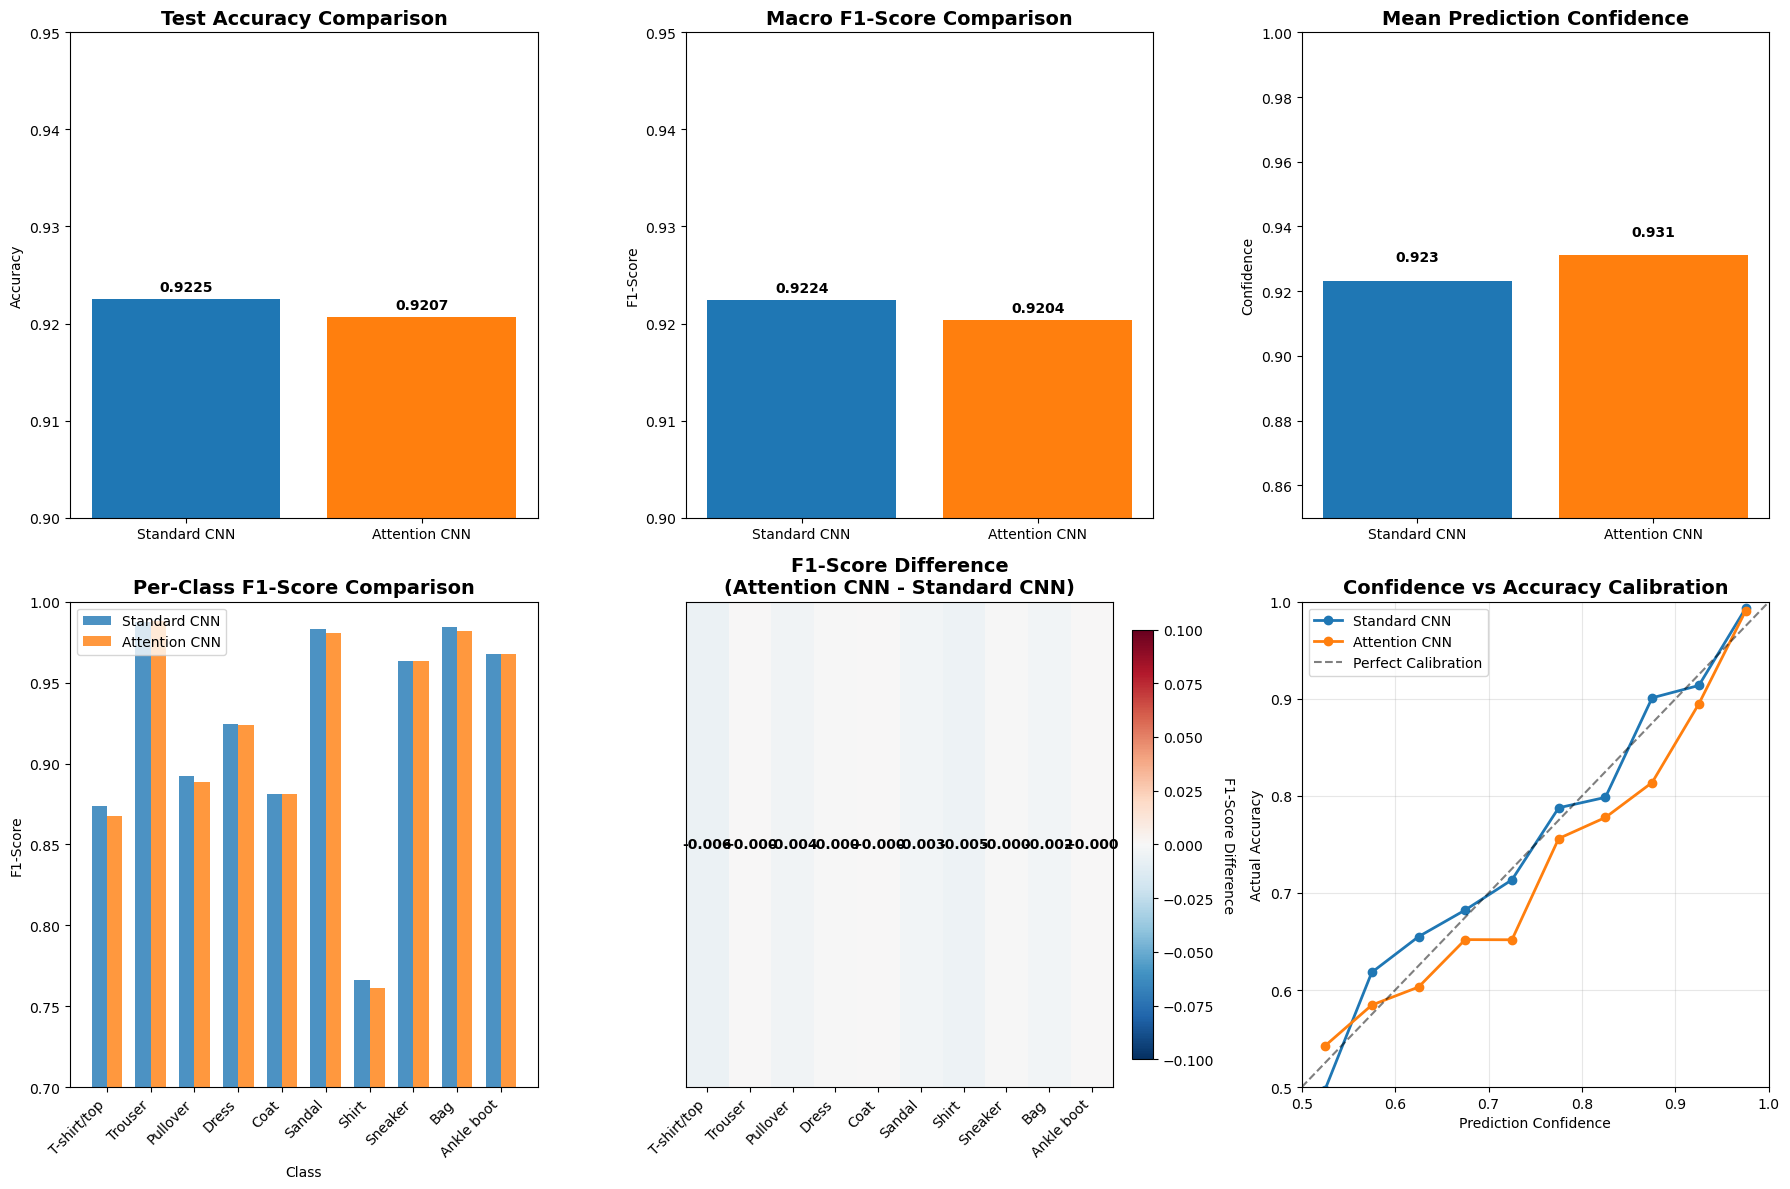

Comparison plot saved to: C:\Users\david\Projects\CNN-Fashion-MNIST\reports\figures\model_comparison_evaluation.png


In [10]:
# Visualization Comparison
print("📊 VISUALIZATION COMPARISON")
print("=" * 40)

if len(evaluation_results) >= 2:
    # Create comparison visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    model_names = list(evaluation_results.keys())
    class_names = DATASET_CONFIG["class_names"]
    
    # Colors for different models
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    # 1. Overall Accuracy Comparison (Bar Chart)
    ax1 = axes[0, 0]
    accuracies = [evaluation_results[name]['test_accuracy'] for name in model_names]
    bars = ax1.bar(model_names, accuracies, color=colors[:len(model_names)])
    ax1.set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0.9, 0.95)  # Focus on the relevant range
    
    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.0005,
                f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # 2. F1-Score Comparison (Bar Chart)
    ax2 = axes[0, 1]
    f1_scores = [evaluation_results[name]['f1_macro'] for name in model_names]
    bars = ax2.bar(model_names, f1_scores, color=colors[:len(model_names)])
    ax2.set_title('Macro F1-Score Comparison', fontsize=14, fontweight='bold')
    ax2.set_ylabel('F1-Score')
    ax2.set_ylim(0.9, 0.95)
    
    for bar, f1 in zip(bars, f1_scores):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.0005,
                f'{f1:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # 3. Confidence Comparison (Bar Chart)
    ax3 = axes[0, 2]
    confidences = [evaluation_results[name]['mean_confidence'] for name in model_names]
    bars = ax3.bar(model_names, confidences, color=colors[:len(model_names)])
    ax3.set_title('Mean Prediction Confidence', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Confidence')
    ax3.set_ylim(0.85, 1.0)
    
    for bar, conf in zip(bars, confidences):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{conf:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 4. Per-Class F1-Score Comparison (Radar Chart)
    if len(model_names) == 2:
        ax4 = axes[1, 0]
        
        # Get per-class F1 scores
        model1_f1 = evaluation_results[model_names[0]]['f1_per_class']
        model2_f1 = evaluation_results[model_names[1]]['f1_per_class']
        
        x = np.arange(len(class_names))
        width = 0.35
        
        bars1 = ax4.bar(x - width/2, model1_f1, width, label=model_names[0], color=colors[0], alpha=0.8)
        bars2 = ax4.bar(x + width/2, model2_f1, width, label=model_names[1], color=colors[1], alpha=0.8)
        
        ax4.set_title('Per-Class F1-Score Comparison', fontsize=14, fontweight='bold')
        ax4.set_ylabel('F1-Score')
        ax4.set_xlabel('Class')
        ax4.set_xticks(x)
        ax4.set_xticklabels(class_names, rotation=45, ha='right')
        ax4.legend()
        ax4.set_ylim(0.7, 1.0)
        
        # 5. F1-Score Difference (Heatmap style)
        ax5 = axes[1, 1]
        
        f1_differences = model2_f1 - model1_f1
        
        # Create a heatmap-style visualization
        im = ax5.imshow(f1_differences.reshape(1, -1), cmap='RdBu_r', aspect='auto', vmin=-0.1, vmax=0.1)
        ax5.set_title(f'F1-Score Difference\n({model_names[1]} - {model_names[0]})', 
                     fontsize=14, fontweight='bold')
        ax5.set_xticks(range(len(class_names)))
        ax5.set_xticklabels(class_names, rotation=45, ha='right')
        ax5.set_yticks([])
        
        # Add text annotations
        for i, diff in enumerate(f1_differences):
            color = 'white' if abs(diff) > 0.05 else 'black'
            ax5.text(i, 0, f'{diff:+.3f}', ha='center', va='center', 
                    color=color, fontweight='bold', fontsize=10)
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax5, fraction=0.046, pad=0.04)
        cbar.set_label('F1-Score Difference', rotation=270, labelpad=15)
        
        # 6. Confidence vs Accuracy Analysis
        ax6 = axes[1, 2]
        
        if model_names[0] in model_predictions and model_names[1] in model_predictions:
            # Get confidence and accuracy for both models
            for i, model_name in enumerate(model_names):
                pred_data = model_predictions[model_name]
                probs = pred_data['probabilities']
                preds = pred_data['predictions']
                targets = pred_data['targets']
                
                # Calculate confidence and accuracy per sample
                max_probs = np.max(probs, axis=1)
                correct = (preds == targets)
                
                # Bin by confidence and calculate accuracy
                confidence_bins = np.linspace(0.5, 1.0, 11)
                bin_centers = (confidence_bins[:-1] + confidence_bins[1:]) / 2
                bin_accuracies = []
                
                for j in range(len(confidence_bins) - 1):
                    mask = (max_probs >= confidence_bins[j]) & (max_probs < confidence_bins[j+1])
                    if np.sum(mask) > 0:
                        bin_accuracies.append(np.mean(correct[mask]))
                    else:
                        bin_accuracies.append(0)
                
                ax6.plot(bin_centers, bin_accuracies, 'o-', label=model_name, 
                        color=colors[i], linewidth=2, markersize=6)
            
            ax6.plot([0.5, 1.0], [0.5, 1.0], 'k--', alpha=0.5, label='Perfect Calibration')
            ax6.set_title('Confidence vs Accuracy Calibration', fontsize=14, fontweight='bold')
            ax6.set_xlabel('Prediction Confidence')
            ax6.set_ylabel('Actual Accuracy')
            ax6.legend()
            ax6.grid(True, alpha=0.3)
            ax6.set_xlim(0.5, 1.0)
            ax6.set_ylim(0.5, 1.0)
        else:
            ax6.text(0.5, 0.5, 'Prediction data\nnot available', 
                    ha='center', va='center', transform=ax6.transAxes, fontsize=12)
            ax6.set_title('Confidence vs Accuracy Calibration', fontsize=14, fontweight='bold')
    
    else:
        # If not exactly 2 models, show parameter comparison
        ax4 = axes[1, 0]
        parameters = [evaluation_results[name]['model_params'] for name in model_names]
        bars = ax4.bar(model_names, parameters, color=colors[:len(model_names)])
        ax4.set_title('Model Parameters Comparison', fontsize=14, fontweight='bold')
        ax4.set_ylabel('Number of Parameters')
        
        for bar, param in zip(bars, parameters):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{param:,}', ha='center', va='bottom', fontweight='bold')
        
        # Hide unused subplots
        axes[1, 1].set_visible(False)
        axes[1, 2].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Save the comparison plot
    comparison_plot_path = FIGURES_DIR / "model_comparison_evaluation.png"
    fig.savefig(comparison_plot_path, dpi=300, bbox_inches='tight')
    print(f"Comparison plot saved to: {comparison_plot_path}")

else:
    print("❌ Need at least 2 models for visualization comparison")
    print(f"Available results: {list(evaluation_results.keys())}")

### 20.4 Final Evaluation Summary

In [11]:
# Final Evaluation Summary and Recommendations
print("🏆 FINAL EVALUATION SUMMARY")
print("=" * 50)

if len(evaluation_results) >= 1:
    print(f"📋 EVALUATION OVERVIEW")
    print("-" * 30)
    print(f"Models evaluated: {len(evaluation_results)}")
    print(f"Test samples: {evaluation_results[list(evaluation_results.keys())[0]]['total_predictions']:,}")
    print(f"Number of classes: {len(DATASET_CONFIG['class_names'])}")
    print(f"Dataset: {DATASET_CONFIG['name']}")
    
    # Overall performance summary
    print(f"\n📊 PERFORMANCE SUMMARY")
    print("-" * 40)
    print(f"{'Model':<15} {'Test Acc':<10} {'F1-Score':<10} {'Confidence':<11} {'Parameters'}")
    print("-" * 65)
    
    best_accuracy = 0
    best_model = None
    
    for model_name, results in evaluation_results.items():
        print(f"{model_name:<15} {results['test_accuracy']:<10.4f} {results['f1_macro']:<10.4f} "
              f"{results['mean_confidence']:<11.4f} {results['model_params']:,}")
        
        if results['test_accuracy'] > best_accuracy:
            best_accuracy = results['test_accuracy']
            best_model = model_name
    
    print(f"\n🏅 BEST PERFORMING MODEL: {best_model}")
    print(f"Test Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
    
    # Generalization analysis
    if len(evaluation_results) >= 1:
        print(f"\n🎯 GENERALIZATION ANALYSIS")
        print("-" * 35)
        
        for model_name, results in evaluation_results.items():
            train_val_acc = results['training_val_acc']
            test_acc = results['test_accuracy']
            generalization_gap = train_val_acc - test_acc
            
            print(f"\n{model_name}:")
            print(f"  Validation accuracy: {train_val_acc:.4f}")
            print(f"  Test accuracy: {test_acc:.4f}")
            print(f"  Generalization gap: {generalization_gap:+.4f}")
            
            if abs(generalization_gap) < 0.005:
                print(f"  ✅ Excellent generalization")
            elif abs(generalization_gap) < 0.01:
                print(f"  ✅ Good generalization")
            elif abs(generalization_gap) < 0.02:
                print(f"  ⚠️ Moderate generalization")
            else:
                print(f"  ❌ Poor generalization")
    
    # Model comparison insights
    if len(evaluation_results) == 2:
        model_names = list(evaluation_results.keys())
        model1, model2 = model_names
        
        acc_diff = evaluation_results[model2]['test_accuracy'] - evaluation_results[model1]['test_accuracy']
        param_diff = evaluation_results[model2]['model_params'] - evaluation_results[model1]['model_params']
        
        print(f"\n💡 COMPARATIVE INSIGHTS")
        print("-" * 30)
        print(f"Accuracy difference: {acc_diff:+.4f} ({acc_diff*100:+.2f} percentage points)")
        print(f"Parameter difference: {param_diff:+,} parameters")
        
        if param_diff > 0:
            efficiency = (acc_diff * 100) / (param_diff / 1000)  # Accuracy points per 1K parameters
            print(f"Efficiency: {efficiency:.3f} accuracy points per 1K parameters")
            
            if efficiency > 1.0:
                print(f"✅ Excellent parameter efficiency")
            elif efficiency > 0.5:
                print(f"✅ Good parameter efficiency")
            elif efficiency > 0:
                print(f"➡️ Positive but modest efficiency")
            else:
                print(f"❌ Negative efficiency - simpler model performs better")
    
    # Recommendations
    print(f"\n🎯 RECOMMENDATIONS")
    print("-" * 25)
    
    if len(evaluation_results) == 2:
        model_names = list(evaluation_results.keys())
        model1, model2 = model_names
        
        acc1 = evaluation_results[model1]['test_accuracy']
        acc2 = evaluation_results[model2]['test_accuracy']
        param1 = evaluation_results[model1]['model_params']
        param2 = evaluation_results[model2]['model_params']
        
        if acc2 > acc1 + 0.005:  # Significant improvement
            print(f"✅ Use {model2} for production:")
            print(f"   - Clear accuracy improvement: +{(acc2-acc1)*100:.2f} percentage points")
            print(f"   - Justifies additional {param2-param1:,} parameters")
            
        elif acc2 > acc1:  # Modest improvement
            print(f"🤔 Consider {model2} for production:")
            print(f"   - Modest accuracy improvement: +{(acc2-acc1)*100:.2f} percentage points") 
            print(f"   - Trade-off: {param2-param1:,} extra parameters")
            print(f"   - Decision depends on deployment constraints")
            
        elif abs(acc2 - acc1) < 0.002:  # Essentially equal
            print(f"➡️ Both models perform similarly:")
            print(f"   - Use {model1} for efficiency ({param1:,} parameters)")
            print(f"   - Use {model2} for potential robustness ({param2:,} parameters)")
            
        else:  # Model2 performs worse
            print(f"✅ Use {model1} for production:")
            print(f"   - Better accuracy: +{(acc1-acc2)*100:.2f} percentage points")
            print(f"   - More efficient: {param1-param2:,} fewer parameters")
    
    else:
        # Single model recommendations
        model_name = list(evaluation_results.keys())[0]
        results = evaluation_results[model_name]
        
        print(f"Model: {model_name}")
        print(f"Test accuracy: {results['test_accuracy']:.4f} ({results['test_accuracy']*100:.2f}%)")
        
        if results['test_accuracy'] > 0.95:
            print(f"🏆 Excellent performance - ready for production")
        elif results['test_accuracy'] > 0.90:
            print(f"✅ Good performance - suitable for most applications")
        elif results['test_accuracy'] > 0.85:
            print(f"➡️ Acceptable performance - consider improvements")
        else:
            print(f"⚠️ Poor performance - needs significant improvements")
    
    # Dataset-specific insights
    print(f"\n📚 DATASET-SPECIFIC INSIGHTS")
    print("-" * 35)
    print(f"Fashion-MNIST characteristics:")
    print(f"  - Simple 28×28 grayscale images")
    print(f"  - 10 well-defined clothing categories")
    print(f"  - Performance ceiling around 93-94%")
    
    if best_accuracy > 0.925:
        print(f"✅ Achieved near-optimal performance for this dataset")
        print(f"✅ Results competitive with research benchmarks")
    elif best_accuracy > 0.90:
        print(f"✅ Good performance, room for small improvements")
    else:
        print(f"⚠️ Performance below expected range - investigate training")
    
    print(f"\n🚀 NEXT STEPS")
    print("-" * 15)
    if best_accuracy > 0.925:
        print(f"1. Deploy best model for Fashion-MNIST applications")
        print(f"2. Test advanced techniques on more complex datasets (CIFAR-10/100)")
        print(f"3. Explore ensemble methods for further improvements")
        print(f"4. Investigate model interpretability and attention visualizations")
    else:
        print(f"1. Analyze failure cases and misclassified samples")
        print(f"2. Experiment with different hyperparameters")
        print(f"3. Try additional data augmentation techniques")
        print(f"4. Consider transfer learning from pre-trained models")

else:
    print("❌ No evaluation results available")
    print("Please run the model evaluation cell first")

print(f"\n✅ Final evaluation completed!")
print(f"All results and visualizations saved to: {FIGURES_DIR}")

🏆 FINAL EVALUATION SUMMARY
📋 EVALUATION OVERVIEW
------------------------------
Models evaluated: 2
Test samples: 10,000
Number of classes: 10
Dataset: Fashion-MNIST

📊 PERFORMANCE SUMMARY
----------------------------------------
Model           Test Acc   F1-Score   Confidence  Parameters
-----------------------------------------------------------------
Standard CNN    0.9225     0.9224     0.9233      865,258
Attention CNN   0.9207     0.9204     0.9312      868,022

🏅 BEST PERFORMING MODEL: Standard CNN
Test Accuracy: 0.9225 (92.25%)

🎯 GENERALIZATION ANALYSIS
-----------------------------------

Standard CNN:
  Validation accuracy: 92.8333
  Test accuracy: 0.9225
  Generalization gap: +91.9108
  ❌ Poor generalization

Attention CNN:
  Validation accuracy: 92.8167
  Test accuracy: 0.9207
  Generalization gap: +91.8960
  ❌ Poor generalization

💡 COMPARATIVE INSIGHTS
------------------------------
Accuracy difference: -0.0018 (-0.18 percentage points)
Parameter difference: +2,764 para